<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, r2_score,mean_squared_error

sns.set_style('ticks')
plt.style.use('seaborn')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
df = pd.read_csv('./housing.csv')
df.shape

(1460, 81)

<font color='blue'><b> I decided that 48 features are 'fixed' characteristics

In [3]:
fixed_features = ['MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley','LotShape','LandContour',
                'Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType',
                'HouseStyle','YearBuilt','YearRemodAdd','RoofStyle','RoofMatl','Exterior1st','Exterior2nd',
                'MasVnrType','MasVnrArea','Foundation','BsmtExposure','TotalBsmtSF', '1stFlrSF','2ndFlrSF',
                'GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr', 'KitchenAbvGr',
                'TotRmsAbvGrd','GarageType','GarageCars','GarageArea','PavedDrive','PoolArea', 'Fireplaces',
                'MiscFeature','MiscVal','YrSold','SaleType','SaleCondition','SalePrice']
len(fixed_features)

49

<font color='blue'><b> Create dataframe containing fixed features only

In [4]:
df_fixed = df.loc[:, fixed_features]

<font color='blue'><b> 'MSZoning': Remove non-residentials. Retain FV, RL, RM and RH.

In [5]:
df_fixed['MSZoning'].unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [6]:
df_fixed = df_fixed[df_fixed['MSZoning'].isin(['RL', 'RM', 'RH', 'FV'])]

In [7]:
df_fixed.shape

(1450, 49)

# <font color='blue'><b> Data Cleaning:

In [8]:
# check datatypes
df_fixed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 49 columns):
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            89 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-null object
Exterior2nd      1450 non-null object
MasVnrType       1442 non-null object
MasVnrArea       1442 no

In [9]:
# see how many null values exist for each feature
df_fixed.isnull().sum().sort_values(ascending=False).head(10)

MiscFeature     1398
Alley           1361
LotFrontage      259
GarageType        79
BsmtExposure      38
MasVnrType         8
MasVnrArea         8
Condition2         0
Exterior1st        0
RoofMatl           0
dtype: int64

### <font color='blue'><b> MiscFeature:

In [10]:
# Look at the unique values and the count of each of them
df_fixed['MiscFeature'].value_counts()

Shed    47
Othr     2
Gar2     2
TenC     1
Name: MiscFeature, dtype: int64

array([nan, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

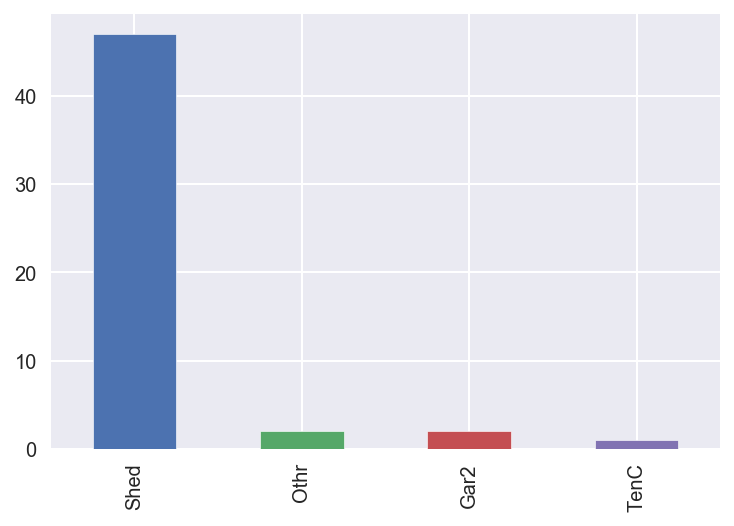

In [11]:
# nan values are effectively houses without any misc features. keep them as nan for now before creating dummies later
pd.Series(df_fixed['MiscFeature']).value_counts().plot('bar')
df_fixed['MiscFeature'].unique()

### <font color='blue'><b> Alley:

Median SalePrice of nulls: 165400.0


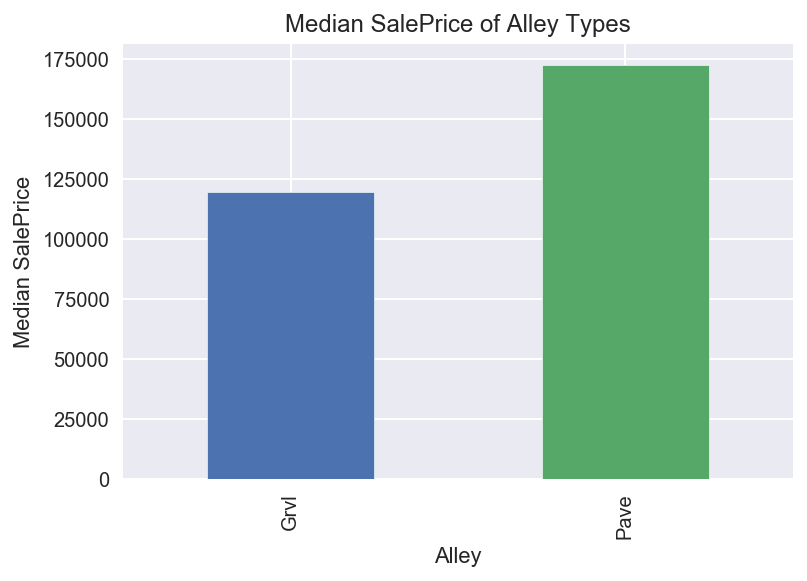

In [12]:
# Grvl, Pave or No Alley (nulls)
# leave the nan. create dummies later
# houses with pavement are generally more expensive than houses with gravel
df_fixed['SalePrice'].groupby(df_fixed['Alley']).median().plot('bar')
print('Median SalePrice of nulls:', df_fixed[df_fixed['Alley'].isnull()].SalePrice.median())
plt.title('Median SalePrice of Alley Types')
plt.ylabel('Median SalePrice')
plt.show()

### <font color='blue'><b> LotFrontage:

In [13]:
# histogram to see distribution
df_fixed['LotFrontage'].describe()

count    1191.000000
mean       70.052897
std        24.301013
min        21.000000
25%        59.000000
50%        70.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

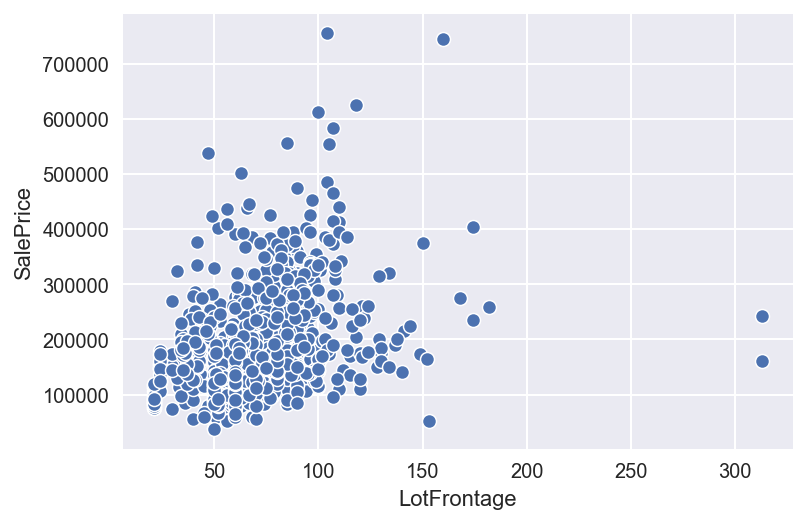

In [14]:
sns.scatterplot(df_fixed['LotFrontage'], df_fixed['SalePrice'])

In [15]:
# fill the null values with the mean LotFrontage of each neighborhood
df_fixed['LotFrontage'].fillna(df_fixed.groupby('Neighborhood')['LotFrontage'].transform("mean"), inplace=True)

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


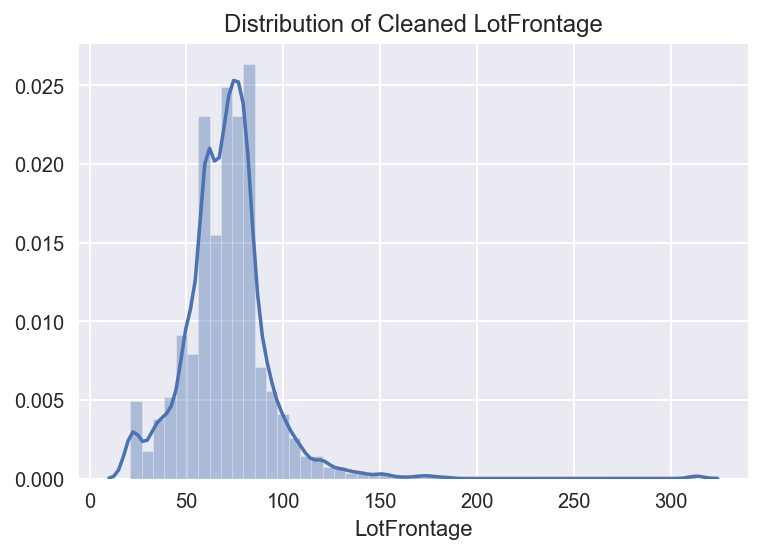

In [16]:
sns.distplot(df_fixed['LotFrontage'])
plt.title('Distribution of Cleaned LotFrontage')
plt.show()

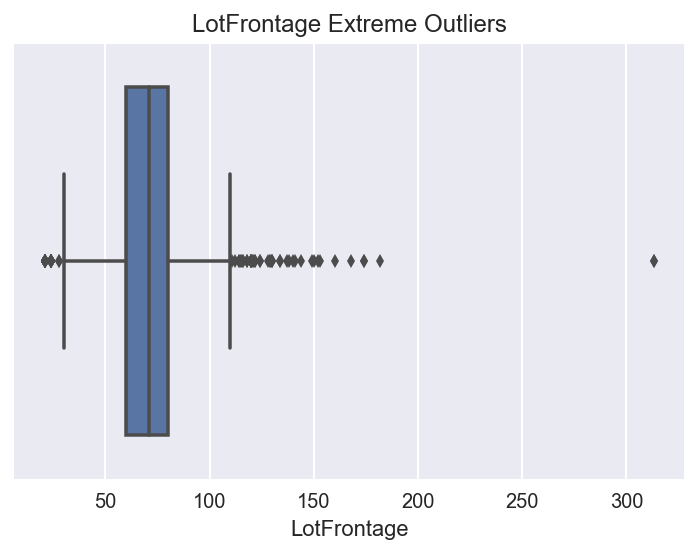

In [17]:
# there are a couple of rows that look like extreme outliers
sns.boxplot(df_fixed['LotFrontage'])
plt.title('LotFrontage Extreme Outliers')
plt.show()

In [18]:
# see what those extreme outliers are
df_fixed[df_fixed['LotFrontage'] > 300]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
934           20       RL        313.0    27650   Pave   NaN      IR2   
1298          60       RL        313.0    63887   Pave   NaN      IR3   

     LandContour Utilities LotConfig    ...    GarageArea PavedDrive PoolArea  \
934          HLS    AllPub    Inside    ...           505          Y        0   
1298         Bnk    AllPub    Corner    ...          1418          Y      480   

     Fireplaces MiscFeature MiscVal  YrSold  SaleType SaleCondition SalePrice  
934           1         NaN       0    2008        WD        Normal    242000  
1298          3         NaN       0    2008       New       Partial    160000  

[2 rows x 49 columns]

In [19]:
# drop those outliers
df_fixed = df_fixed[df_fixed['LotFrontage'] < 300]
df_fixed.shape

(1448, 49)

### <font color='blue'><b> GarageType:

In [20]:
df_fixed['GarageType'].value_counts()

Attchd     868
Detchd     381
BuiltIn     88
Basment     18
CarPort      8
2Types       6
Name: GarageType, dtype: int64

Mean SalePrice of nulls: 104415.18987341772


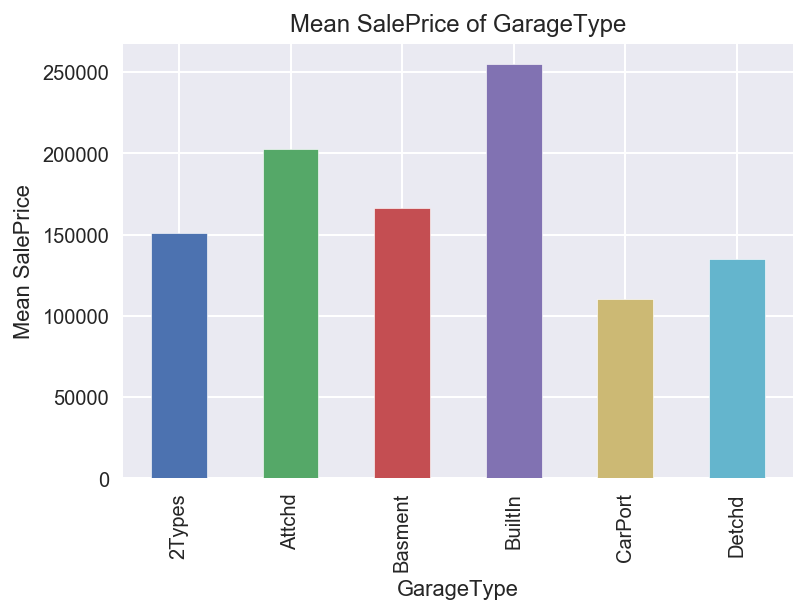

In [21]:
# average SalePrice of having any type of garage is higher than having no garage
# leave the null values there. create dummies later
df_fixed['SalePrice'].groupby(df_fixed['GarageType']).mean().plot('bar')
print('Mean SalePrice of nulls:', df_fixed[df_fixed['GarageType'].isnull()].SalePrice.mean())
plt.ylabel('Mean SalePrice')
plt.title('Mean SalePrice of GarageType')
plt.show()

### <font color='blue'><b> BsmtExposure:

In [22]:
df_fixed['BsmtExposure'].value_counts()

No    947
Av    219
Gd    132
Mn    112
Name: BsmtExposure, dtype: int64

Mean SalePrice of nulls: 107938.34210526316


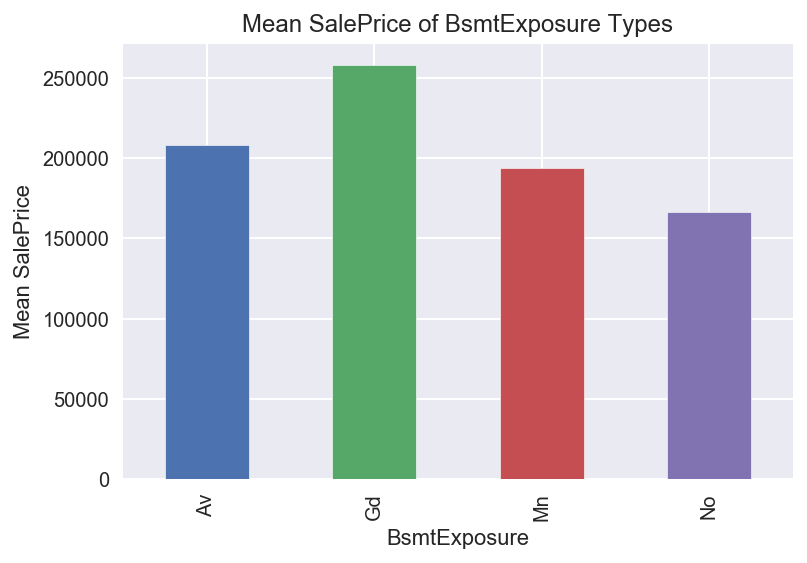

In [23]:
# average SalePrice of having any sort of basement exposure is higher than that of not having basement
# null values will be used as reference for dummies later
df_fixed['SalePrice'].groupby(df_fixed['BsmtExposure']).mean().plot('bar')
print('Mean SalePrice of nulls:', df_fixed[df_fixed['BsmtExposure'].isnull()].SalePrice.mean())
plt.title('Mean SalePrice of BsmtExposure Types')
plt.ylabel('Mean SalePrice')
plt.show()

### <font color='blue'><b> MasVnrType:

In [24]:
df_fixed['MasVnrType'].value_counts()

None       853
BrkFace    445
Stone      127
BrkCmn      15
Name: MasVnrType, dtype: int64

Mean SalePrice of nulls: 236484.25


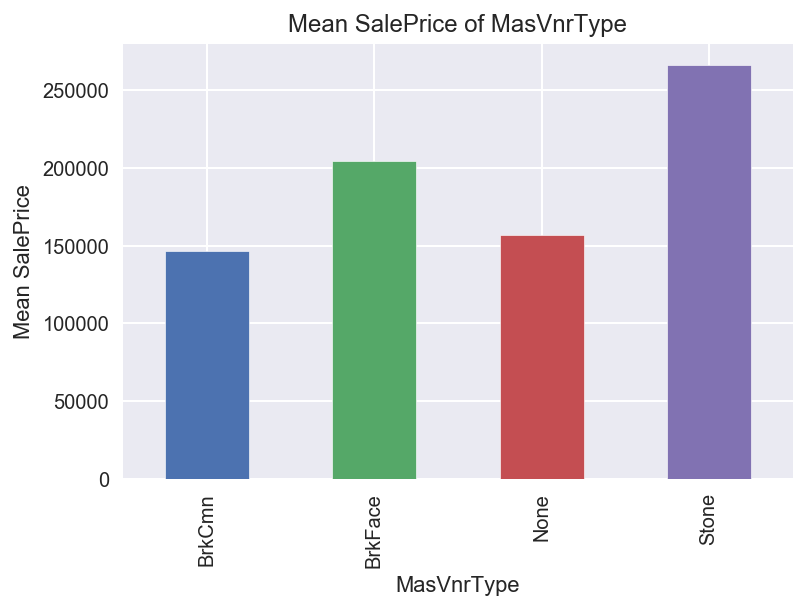

In [25]:
df_fixed['SalePrice'].groupby(df_fixed['MasVnrType']).mean().plot('bar')
print('Mean SalePrice of nulls:', df_fixed[df_fixed['MasVnrType'].isnull()].SalePrice.mean())
plt.title('Mean SalePrice of MasVnrType')
plt.ylabel('Mean SalePrice')
plt.show()

In [26]:
# Replace 'None' with np.nan
df_fixed['MasVnrType'].replace('None', np.nan, inplace=True)

### <font color='blue'><b> MasVnrArea:

In [27]:
df_fixed['MasVnrArea'].describe()

count    1440.000000
mean      103.996528
std       180.673778
min         0.000000
25%         0.000000
50%         0.000000
75%       166.250000
max      1600.000000
Name: MasVnrArea, dtype: float64

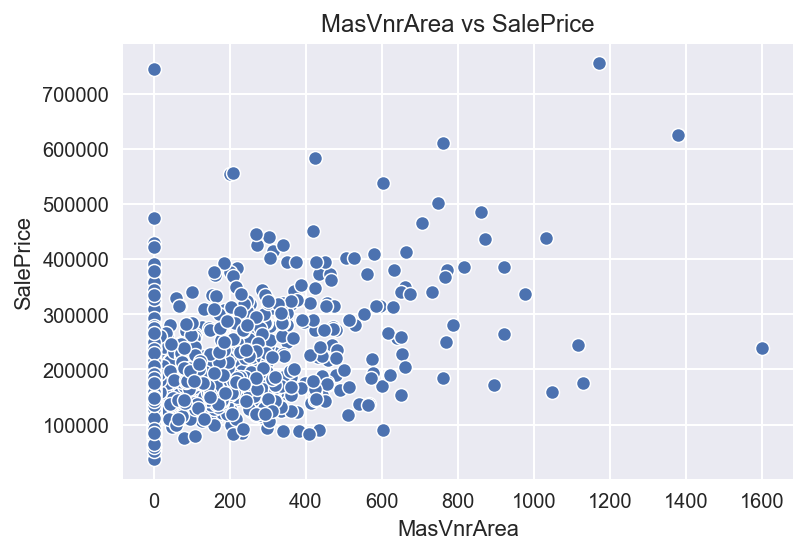

In [28]:
sns.scatterplot(df_fixed['MasVnrArea'], df_fixed['SalePrice'])
plt.title('MasVnrArea vs SalePrice')
plt.show()

In [29]:
# Replace null with 0
df_fixed['MasVnrArea'].replace(np.nan, 0, inplace=True)

In [30]:
df_fixed['MasVnrArea'].describe()

count    1448.000000
mean      103.421961
std       180.338584
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

# <font color='blue'><b> Analysis of Numerical Features:

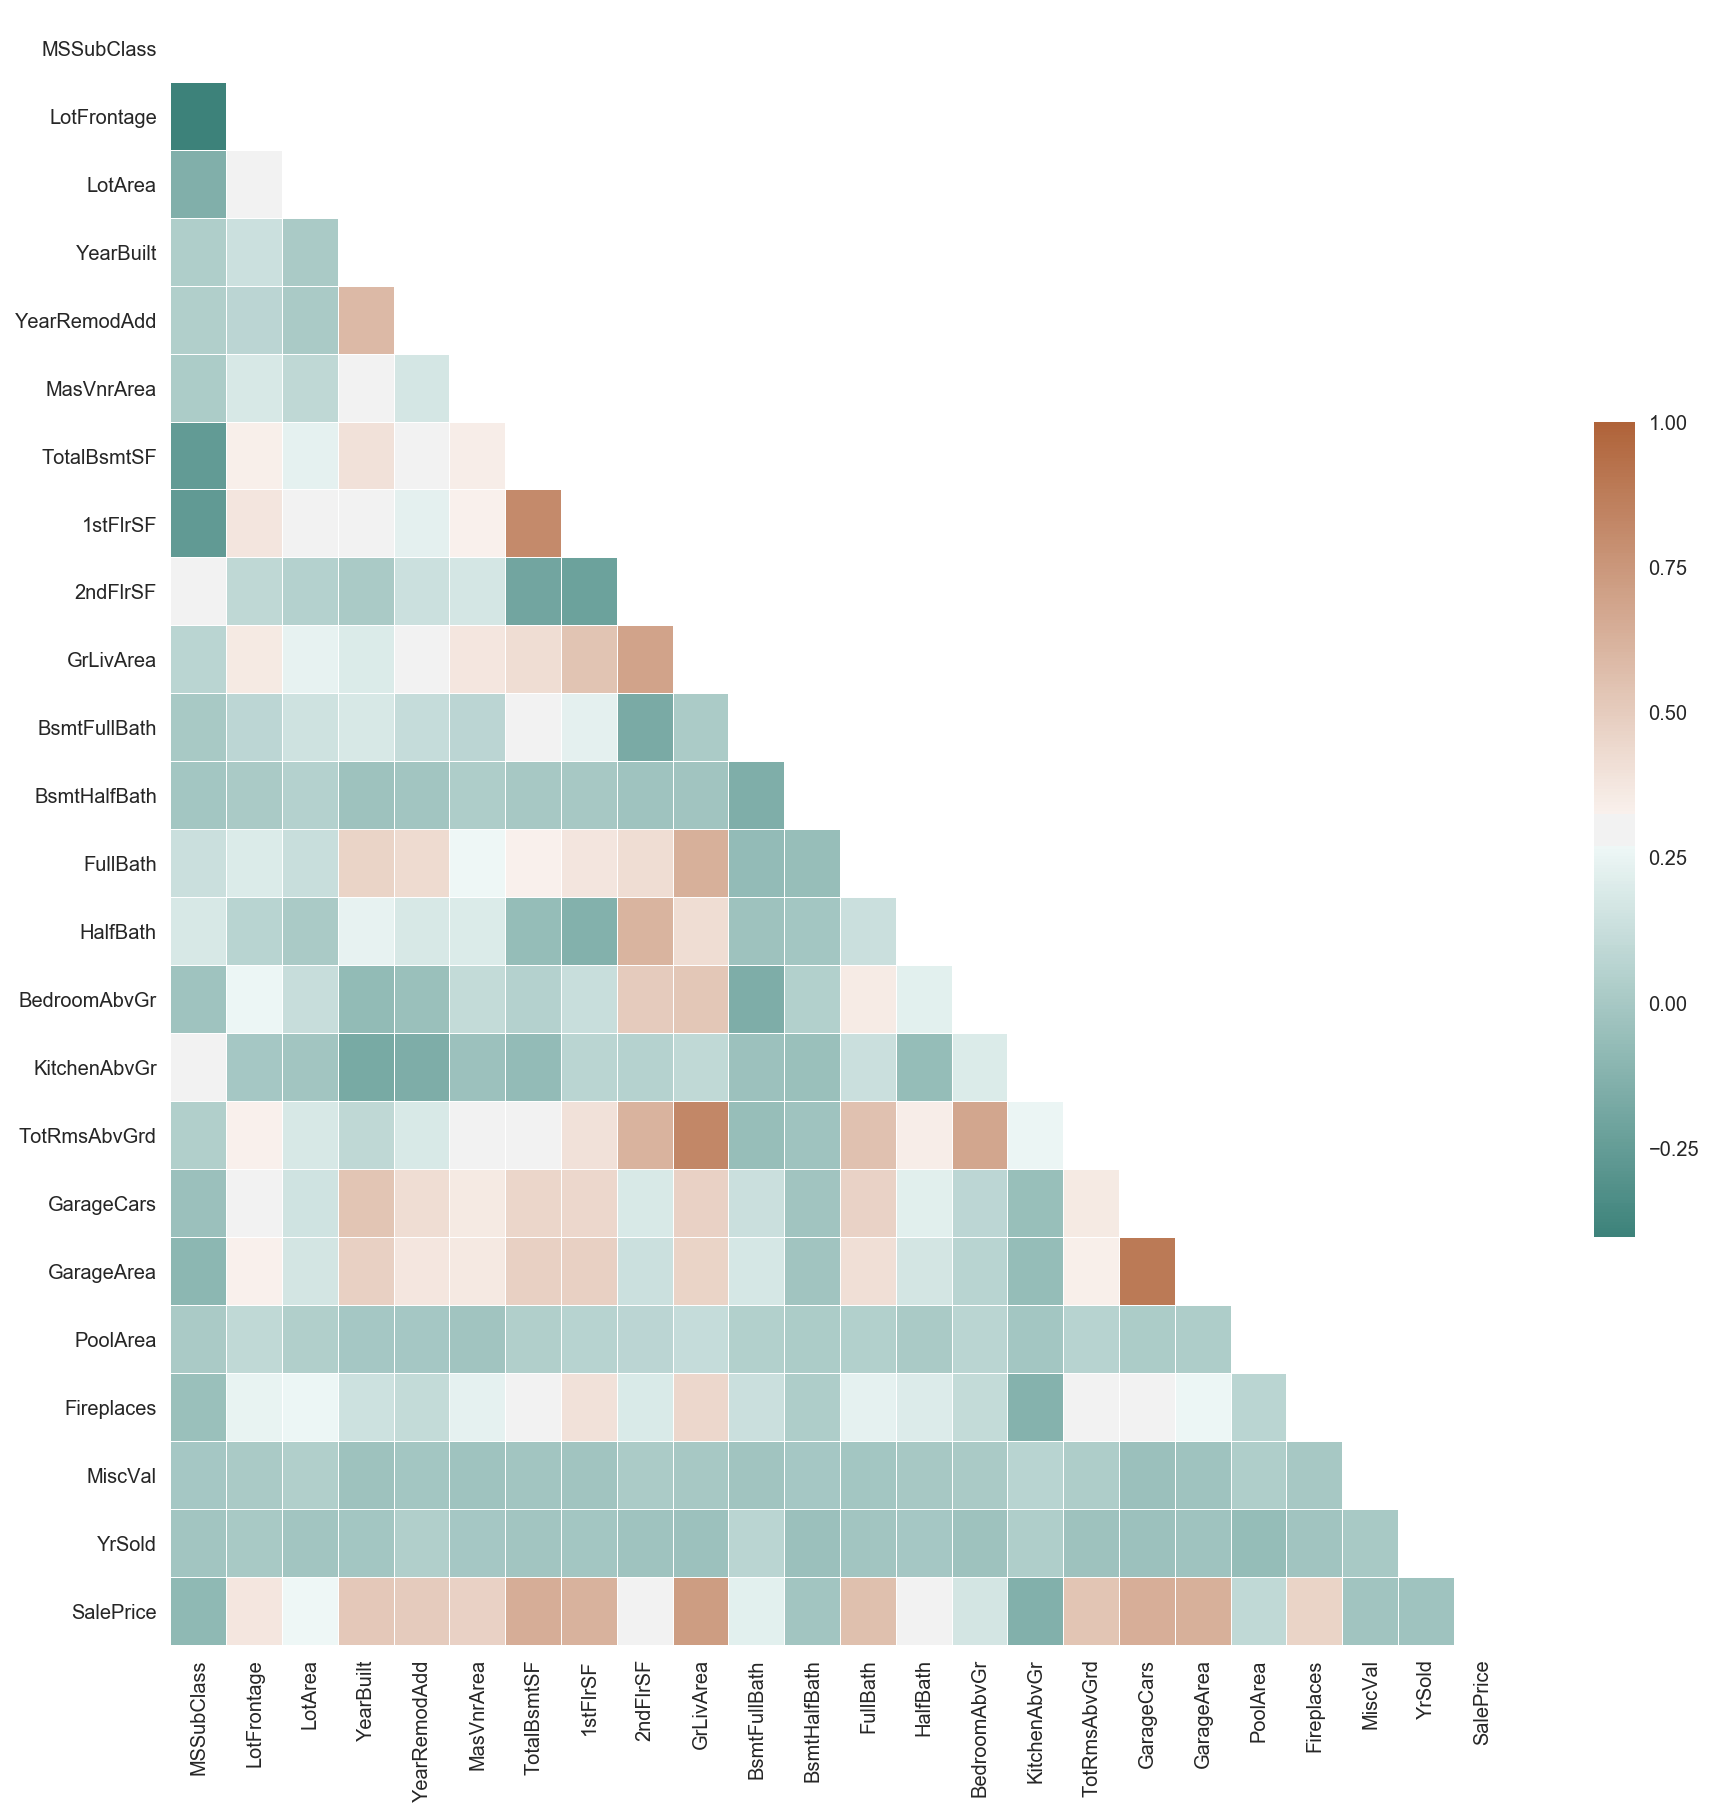

In [31]:
# use heatmap to look at correlation of numerical features against SalePrice
mask = np.zeros_like(df_fixed.corr())
mask[np.triu_indices_from(mask)]=True
cmap = sns.diverging_palette(180, 30, as_cmap=True)
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(15,15))
    heat=sns.heatmap(df_fixed.corr(), mask=mask, cmap=cmap, cbar_kws={'shrink':.5}, linewidth=.01);
       
fig=heat.get_figure()

In [32]:
# look at absolute correlation values with respect to SalePrice
corr_list = df_fixed.corr()
corr_list['SalePrice'].abs().sort_values(ascending=False)

SalePrice       1.000000
GrLivArea       0.725655
TotalBsmtSF     0.645407
GarageCars      0.642219
GarageArea      0.635080
1stFlrSF        0.623323
FullBath        0.556772
TotRmsAbvGrd    0.535848
YearBuilt       0.518441
YearRemodAdd    0.501362
MasVnrArea      0.474637
Fireplaces      0.466013
LotFrontage     0.377824
2ndFlrSF        0.320805
HalfBath        0.281780
LotArea         0.267794
BsmtFullBath    0.224903
BedroomAbvGr    0.161453
KitchenAbvGr    0.137789
PoolArea        0.099628
MSSubClass      0.087056
YrSold          0.025445
MiscVal         0.021028
BsmtHalfBath    0.017485
Name: SalePrice, dtype: float64

In [33]:
# remove those with very low correlation against SalePrice (< 0.2)
df_fixed = df_fixed.drop(columns=['BsmtHalfBath', 'MiscVal', 'MSSubClass', 'PoolArea', 'KitchenAbvGr',
                                  'BedroomAbvGr'])

### <font color='blue'><b> Feature Engineer ('TotalSF'):

In [34]:
df_fixed['TotalSF'] = df_fixed['TotalBsmtSF'] + df_fixed['1stFlrSF'] + df_fixed['2ndFlrSF']
df_fixed.drop(columns=['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], inplace=True)

In [35]:
# corr for TotalSF is stronger than the floor level SF seperately
corr_list = df_fixed.corr()
corr_list['SalePrice'].abs().sort_values(ascending=False)

SalePrice       1.000000
TotalSF         0.820135
GrLivArea       0.725655
GarageCars      0.642219
GarageArea      0.635080
FullBath        0.556772
TotRmsAbvGrd    0.535848
YearBuilt       0.518441
YearRemodAdd    0.501362
MasVnrArea      0.474637
Fireplaces      0.466013
LotFrontage     0.377824
HalfBath        0.281780
LotArea         0.267794
BsmtFullBath    0.224903
YrSold          0.025445
Name: SalePrice, dtype: float64

In [36]:
# remaining features
print('No. of Columns:', len(df_fixed))
df_fixed.columns

No. of Columns: 1448


Index(['MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'Foundation', 'BsmtExposure', 'GrLivArea',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'GarageType',
       'GarageCars', 'GarageArea', 'PavedDrive', 'Fireplaces', 'MiscFeature',
       'YrSold', 'SaleType', 'SaleCondition', 'SalePrice', 'TotalSF'],
      dtype='object')

# <font color='blue'><b> Analysis of Categorical Features:

### <font color='blue'><b> Utilities:

In [37]:
df_fixed['Utilities'].value_counts()

AllPub    1447
NoSeWa       1
Name: Utilities, dtype: int64

In [38]:
# NoSeWa does not contribute to very low nor high SalePrice.
df_fixed[df_fixed['Utilities'] == 'NoSeWa']

MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour  \
944       RL    80.133333    14375   Pave   NaN      IR1         Lvl   

    Utilities LotConfig LandSlope   ...   GarageCars GarageArea PavedDrive  \
944    NoSeWa   CulDSac       Gtl   ...            2        525          Y   

    Fireplaces MiscFeature  YrSold  SaleType SaleCondition SalePrice TotalSF  
944          1         NaN    2009       COD       Abnorml    137500    2163  

[1 rows x 41 columns]

In [39]:
# Drop 'Utilities' due to the feature's low variance. Doubt this will have any power of explaination to SalePrice
df_fixed.drop(columns='Utilities', inplace=True)

### <font color='blue'><b> MSZoning:

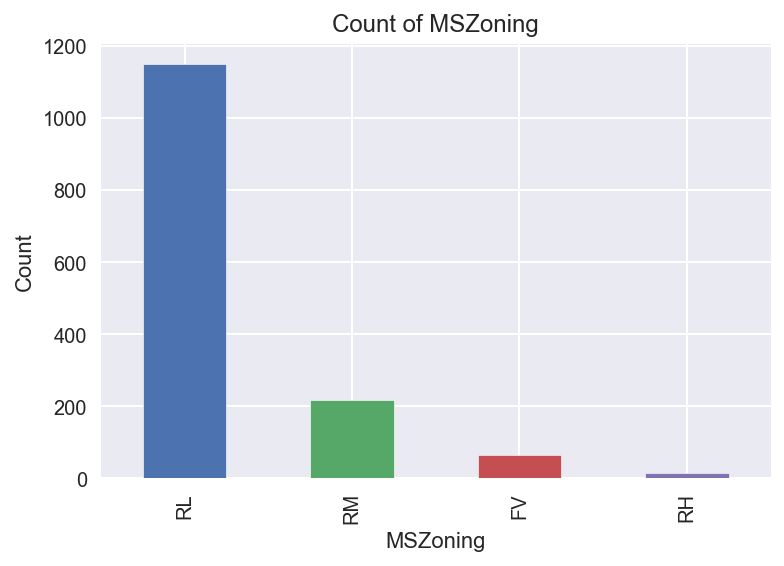

In [40]:
# replace missing values with most common category 'RL'
pd.Series(df_fixed['MSZoning']).value_counts().plot('bar')
df_fixed['MSZoning'] = df_fixed['MSZoning'].fillna(df_fixed['MSZoning'].mode()[0])
plt.title('Count of MSZoning')
plt.ylabel('Count')
plt.xlabel('MSZoning')
plt.show()

### <font color='blue'><b> Street:

Pave    1444
Grvl       4
Name: Street, dtype: int64


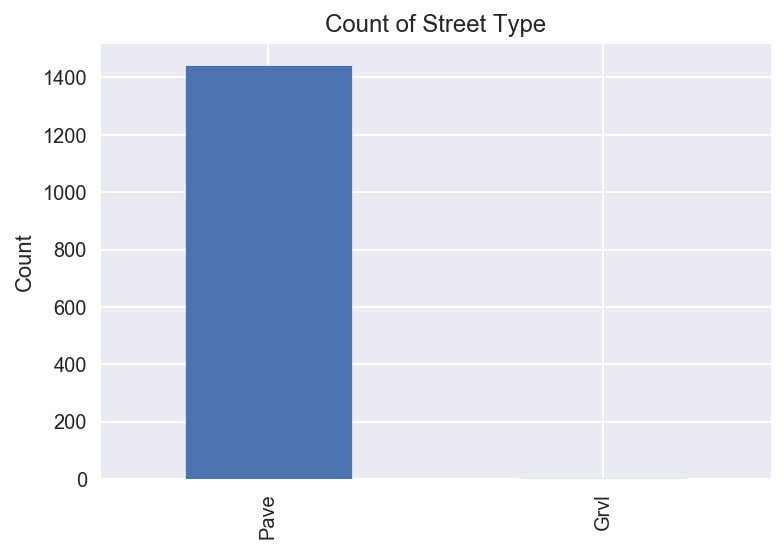

In [41]:
print(df_fixed['Street'].value_counts())
pd.Series(df_fixed['Street']).value_counts().plot('bar')
plt.title('Count of Street Type')
plt.ylabel('Count')
plt.show()

In [42]:
df_fixed[df_fixed['Street'] == 'Grvl']

MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour  \
52         RM   110.000000     8472   Grvl   NaN      IR2         Bnk   
335        RL    80.133333   164660   Grvl   NaN      IR1         HLS   
582        RL    81.000000    11841   Grvl   NaN      Reg         Lvl   
1184       RL    50.000000    35133   Grvl   NaN      Reg         Lvl   

     LotConfig LandSlope Neighborhood   ...   GarageCars GarageArea  \
52      Corner       Mod       IDOTRR   ...            2        516   
335     Corner       Sev       Timber   ...            2        529   
582     Inside       Gtl      Edwards   ...            0          0   
1184    Inside       Mod       Timber   ...            3        995   

     PavedDrive Fireplaces  MiscFeature  YrSold SaleType SaleCondition  \
52            Y          0          NaN    2010       WD        Normal   
335           Y          2         Shed    2008       WD        Normal   
582           Y          0          NaN    2007       WD        Normal   
1184          Y          2          NaN    2007       WD        Normal   

     SalePrice TotalSF  
52      110000    1632  
335     228950    3285  
582     118500    1632  
1184    186700    3144  

[4 rows x 40 columns]

In [43]:
# Drop this feature due to the lack of variance
df_fixed.drop(columns='Street', inplace=True)

# <font color='blue'><b> Analysis of SalePrice:

In [44]:
# Average SalePrice in dataset
df_fixed['SalePrice'].mean()

181628.22237569062

YrSold
2006    183260.317308
2007    186222.185976
2008    177982.316667
2009    180143.306548
2010    179167.000000
Name: SalePrice, dtype: float64


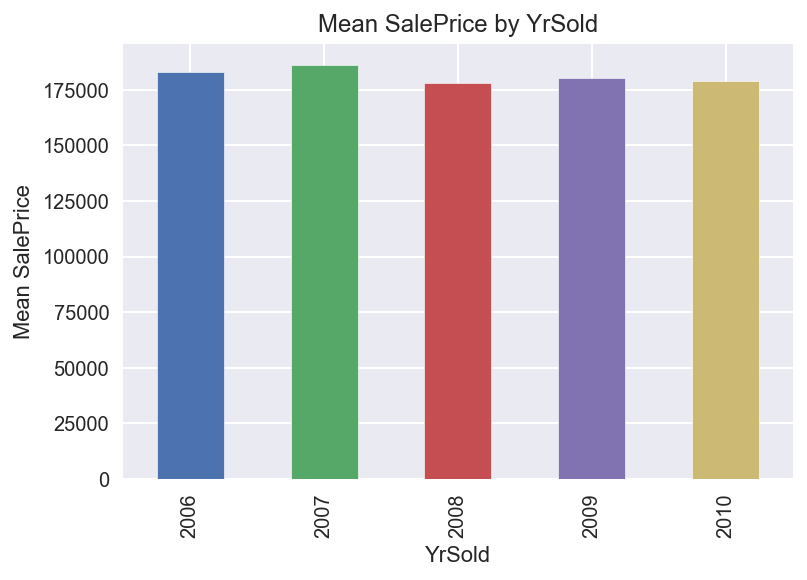

In [45]:
# Average SalePrice by YrSold
avg_price_year = df_fixed['SalePrice'].groupby(df_fixed['YrSold']).mean()
print(avg_price_year)
avg_price_year.plot('bar')
plt.title('Mean SalePrice by YrSold')
plt.ylabel('Mean SalePrice')
plt.show()

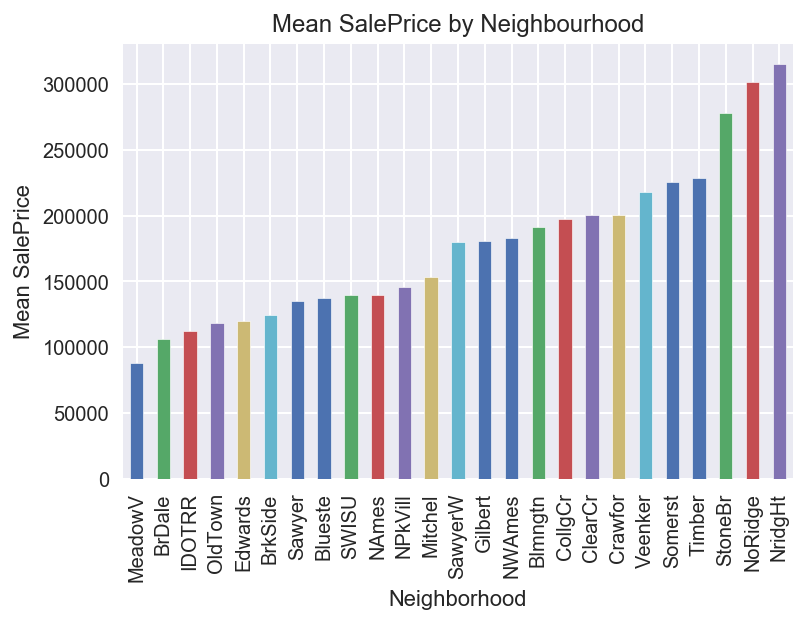

In [46]:
# Median SalePrice by Neighbourhood
df_fixed['SalePrice'].groupby(df['Neighborhood']).median().sort_values().plot('bar')
plt.title('Mean SalePrice by Neighbourhood')
plt.ylabel('Mean SalePrice')
plt.show()

In [47]:
# FINALLY, A TOTAL OF 39 'FIXED' FEATURES
df_fixed.shape

(1448, 39)

### <font color='blue'><b> Apply Log Transformation to SalePrice:

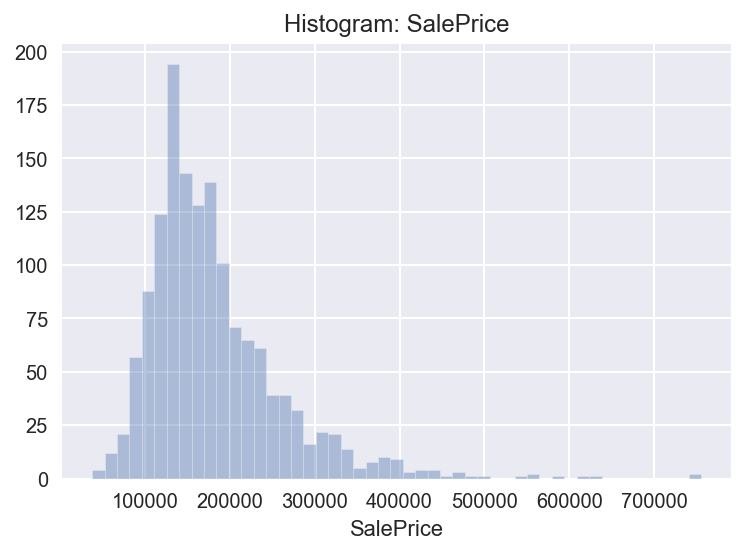

In [48]:
# Pre Transformation
sns.distplot(df_fixed['SalePrice'], kde=False)
plt.title('Histogram: SalePrice')
plt.show()

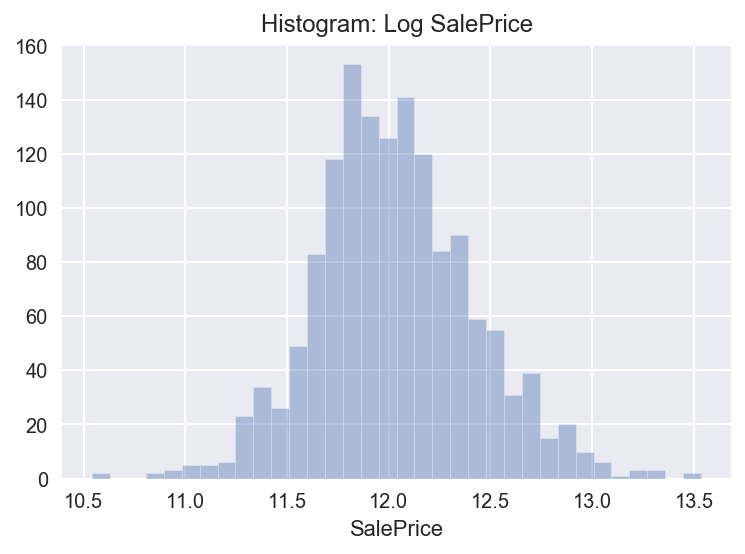

In [49]:
# Post Log Transformation
df_fixed['SalePrice'] = np.log(df_fixed['SalePrice'])
sns.distplot(df_fixed['SalePrice'], kde=False)
plt.title('Histogram: Log SalePrice')
plt.show()

# <font color='blue'><b> Distribution of Selected Numerical Features:

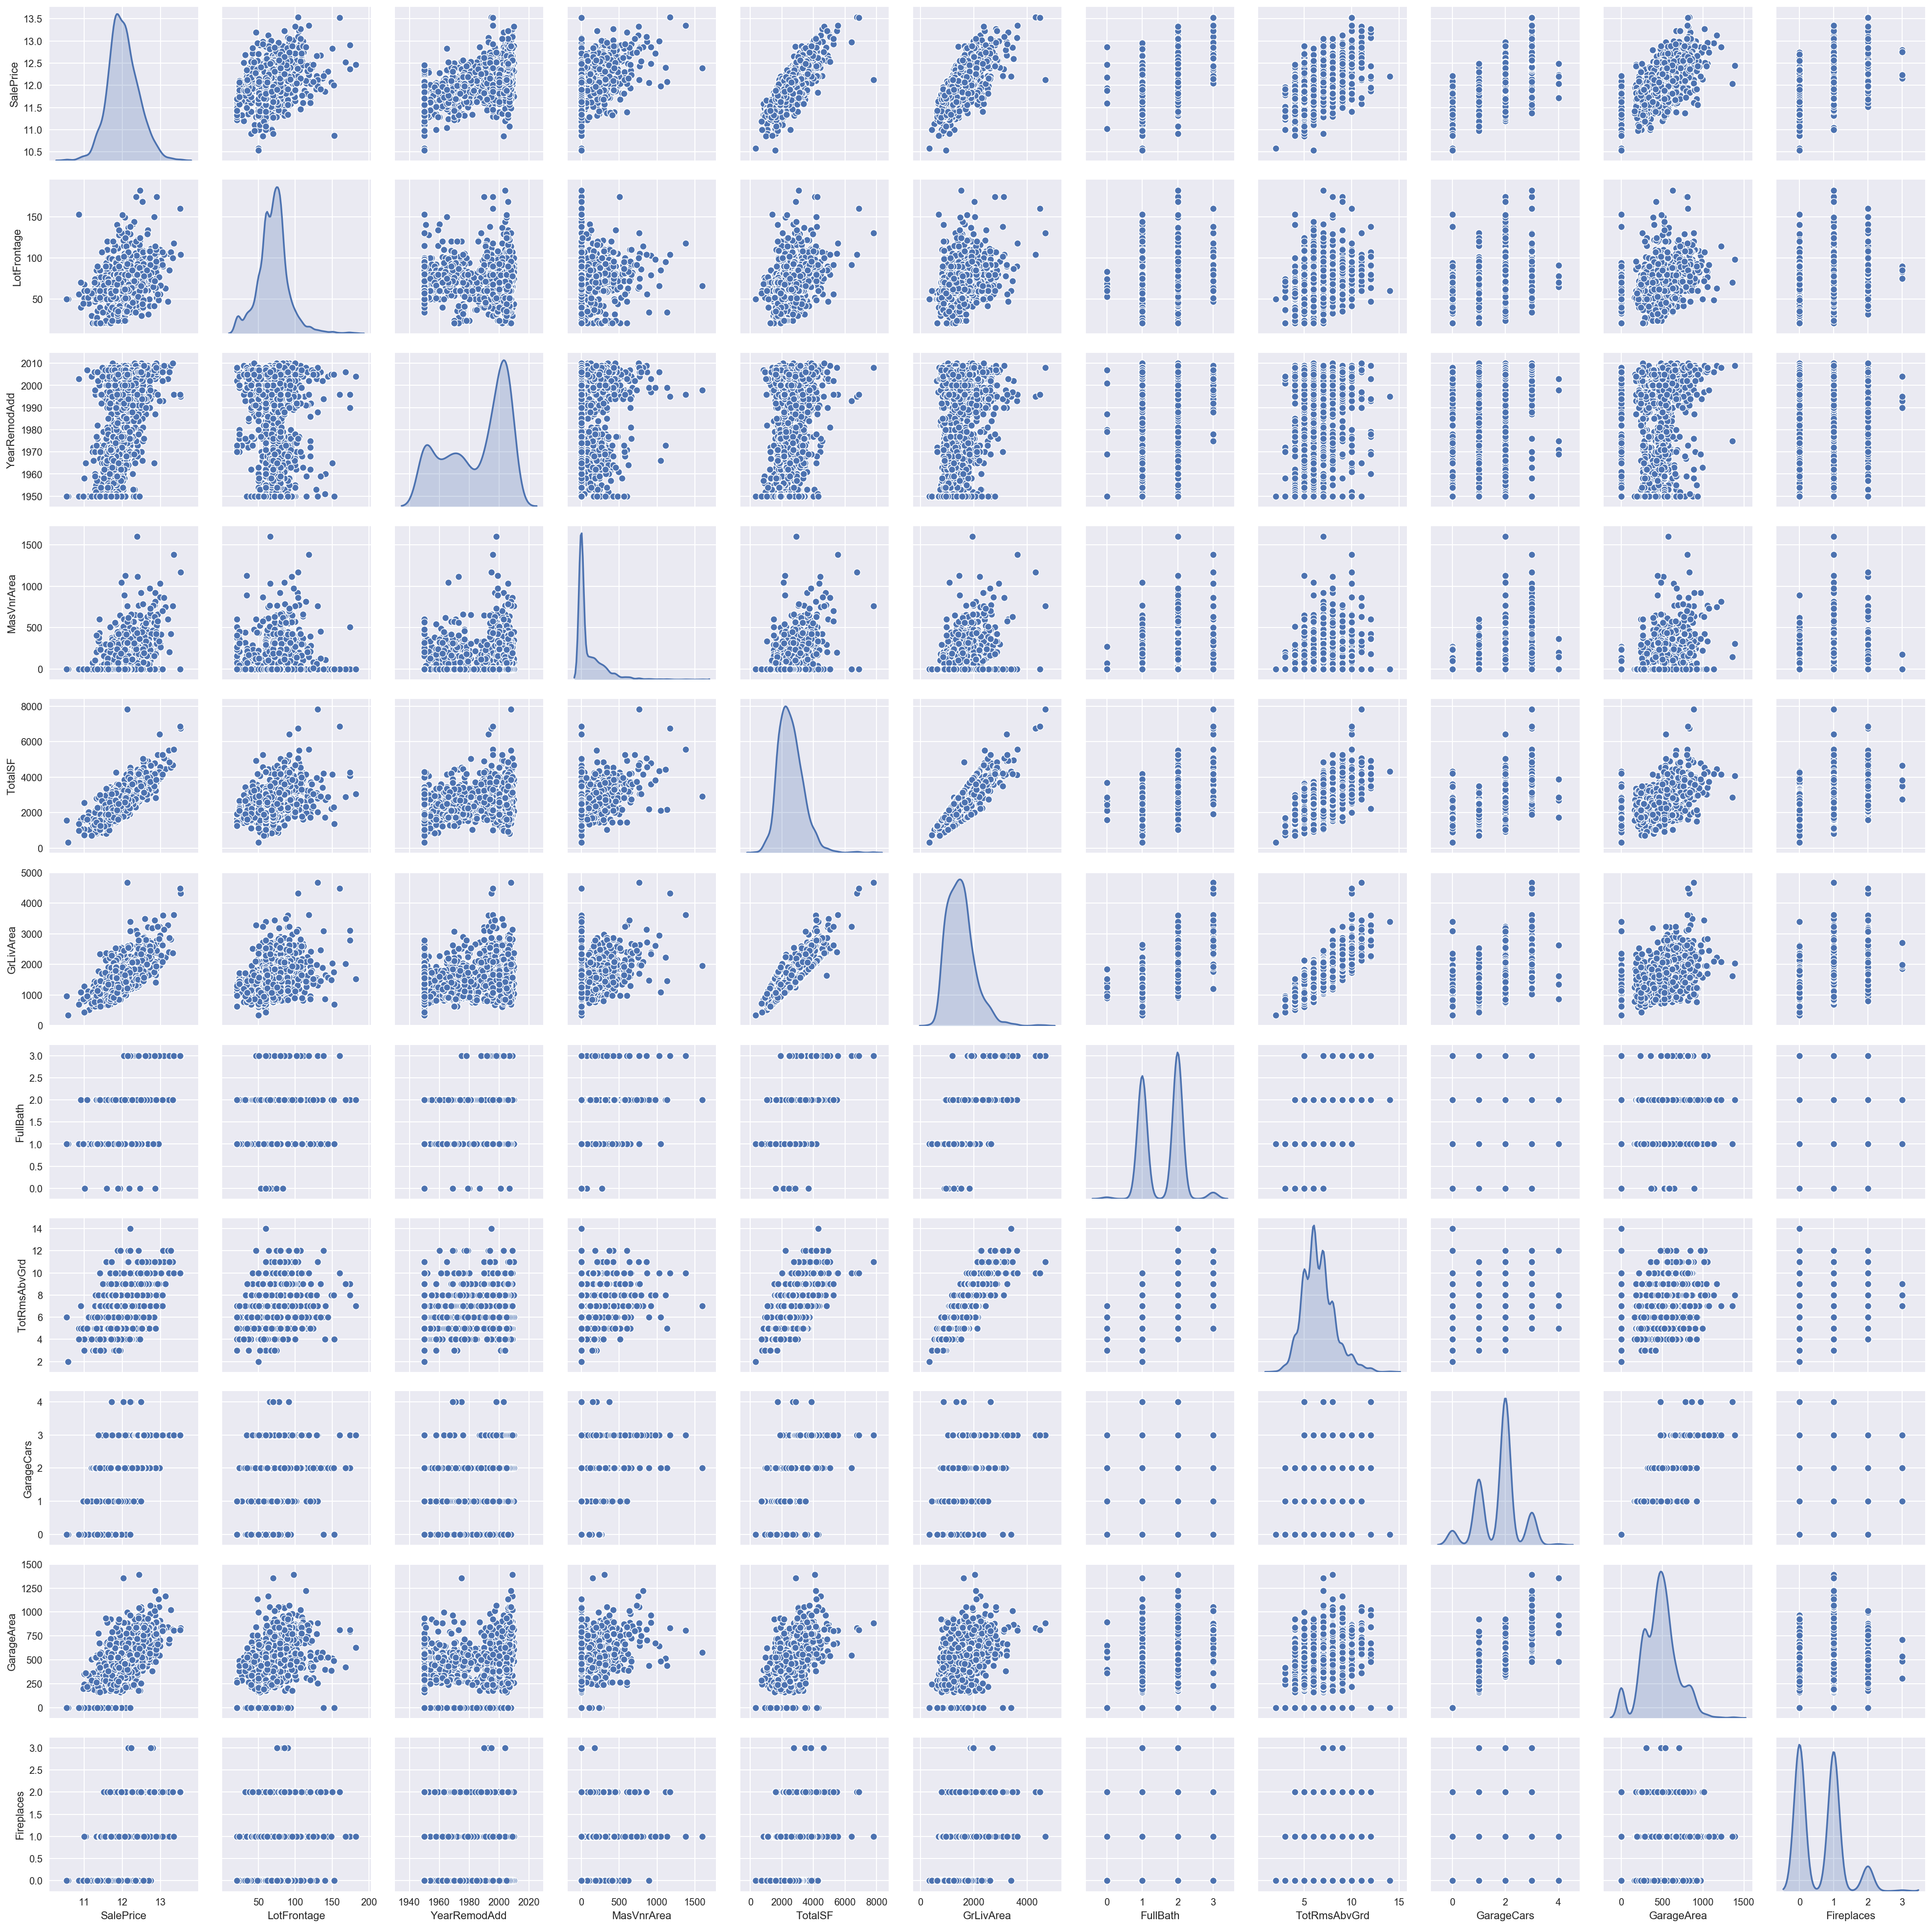

In [50]:
# pairplot on selected numerical features
numerical_plot = ['SalePrice','LotFrontage', 'YearRemodAdd','MasVnrArea','TotalSF','GrLivArea',
                  'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'Fireplaces']
sns.pairplot(df_fixed[numerical_plot],diag_kind='kde')
plt.show()

In [51]:
# check skew
skew_feats = df_fixed[numerical_plot].skew().sort_values(ascending=False)
skew_feats

MasVnrArea      2.674627
GrLivArea       1.127352
TotalSF         0.962315
TotRmsAbvGrd    0.668684
Fireplaces      0.624190
LotFrontage     0.601796
SalePrice       0.236338
GarageArea      0.113811
FullBath        0.040025
GarageCars     -0.341275
YearRemodAdd   -0.512774
dtype: float64

In [52]:
# # plot boxplots of those with skewness > +-0.5
# box = df_fixed.loc[:, ('MasVnrArea', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', '2ndFlrSF')]
# sns.boxplot(data=box, orient='h')
# plt.show()

In [53]:
# # plot boxplots of those with skewness > +-0.5
# box = df_fixed.loc[:, ('TotRmsAbvGrd', 'Fireplaces')]
# sns.boxplot(data=box, orient='h')
# plt.show()

In [54]:
# # plot boxplots of those with skewness > +-0.5
# box = df_fixed.loc[:, ('YearRemodAdd')]
# sns.boxplot(data=box, orient='h')
# plt.show()

# <font color='blue'><b> Seperate Numerical & Categorical Features:

In [55]:
# seperate categorical features from numerical
df_fixed.columns.to_series().groupby(df_fixed.dtypes).groups

{dtype('int64'): Index(['LotArea', 'YearBuilt', 'YearRemodAdd', 'GrLivArea', 'BsmtFullBath',
        'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea',
        'Fireplaces', 'YrSold', 'TotalSF'],
       dtype='object'),
 dtype('float64'): Index(['LotFrontage', 'MasVnrArea', 'SalePrice'], dtype='object'),
 dtype('O'): Index(['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
        'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
        'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
        'MasVnrType', 'Foundation', 'BsmtExposure', 'GarageType', 'PavedDrive',
        'MiscFeature', 'SaleType', 'SaleCondition'],
       dtype='object')}

### <font color='blue'><b> Categorical:

In [56]:
df_fixed_cat = df_fixed.loc[:,['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
        'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
        'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
        'MasVnrType', 'Foundation', 'BsmtExposure', 'GarageType', 'PavedDrive',
        'MiscFeature', 'SaleType', 'SaleCondition']]
df_fixed_cat.columns

Index(['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'Foundation', 'BsmtExposure', 'GarageType', 'PavedDrive',
       'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

In [57]:
df_fixed_cat.head()

MSZoning Alley LotShape LandContour LotConfig LandSlope Neighborhood  \
0       RL   NaN      Reg         Lvl    Inside       Gtl      CollgCr   
1       RL   NaN      Reg         Lvl       FR2       Gtl      Veenker   
2       RL   NaN      IR1         Lvl    Inside       Gtl      CollgCr   
3       RL   NaN      IR1         Lvl    Corner       Gtl      Crawfor   
4       RL   NaN      IR1         Lvl       FR2       Gtl      NoRidge   

  Condition1 Condition2 BldgType      ...      Exterior1st Exterior2nd  \
0       Norm       Norm     1Fam      ...          VinylSd     VinylSd   
1      Feedr       Norm     1Fam      ...          MetalSd     MetalSd   
2       Norm       Norm     1Fam      ...          VinylSd     VinylSd   
3       Norm       Norm     1Fam      ...          Wd Sdng     Wd Shng   
4       Norm       Norm     1Fam      ...          VinylSd     VinylSd   

  MasVnrType Foundation BsmtExposure GarageType PavedDrive MiscFeature  \
0    BrkFace      PConc           No     Attchd          Y         NaN   
1        NaN     CBlock           Gd     Attchd          Y         NaN   
2    BrkFace      PConc           Mn     Attchd          Y         NaN   
3        NaN     BrkTil           No     Detchd          Y         NaN   
4    BrkFace      PConc           Av     Attchd          Y         NaN   

  SaleType SaleCondition  
0       WD        Normal  
1       WD        Normal  
2       WD        Normal  
3       WD       Abnorml  
4       WD        Normal  

[5 rows x 23 columns]

### <font color='blue'><b> Numerical + SalePrice:

In [58]:
df_fixed_num = df_fixed.drop(columns=['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
        'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
        'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
        'MasVnrType', 'Foundation', 'BsmtExposure', 'GarageType', 'PavedDrive',
        'MiscFeature', 'SaleType', 'SaleCondition'])
df_fixed_num.columns

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'TotRmsAbvGrd',
       'GarageCars', 'GarageArea', 'Fireplaces', 'YrSold', 'SalePrice',
       'TotalSF'],
      dtype='object')

In [59]:
df_fixed_num.head()

LotFrontage  LotArea  YearBuilt  YearRemodAdd  MasVnrArea  GrLivArea  \
0         65.0     8450       2003          2003       196.0       1710   
1         80.0     9600       1976          1976         0.0       1262   
2         68.0    11250       2001          2002       162.0       1786   
3         60.0     9550       1915          1970         0.0       1717   
4         84.0    14260       2000          2000       350.0       2198   

   BsmtFullBath  FullBath  HalfBath  TotRmsAbvGrd  GarageCars  GarageArea  \
0             1         2         1             8           2         548   
1             0         2         0             6           2         460   
2             1         2         1             6           2         608   
3             1         1         0             7           3         642   
4             1         2         1             9           3         836   

   Fireplaces  YrSold  SalePrice  TotalSF  
0           0    2008  12.247694     2566  
1           1    2007  12.109011     2524  
2           1    2008  12.317167     2706  
3           1    2006  11.849398     2473  
4           1    2008  12.429216     3343

### <font color='blue'><b> Create Dummies of Categorical Features:

In [60]:
df_fixed_cat.columns

Index(['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'Foundation', 'BsmtExposure', 'GarageType', 'PavedDrive',
       'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

In [61]:
# MSZoning: mean SalePrice for RM is lowest, hence drop it as reference
dummies = pd.get_dummies(df_fixed_cat['MSZoning'], prefix='MSZoning').drop(columns='MSZoning_RM')
dummies.head()

# Alley: null being dropped as reference
temp = pd.get_dummies(df_fixed_cat['Alley'], prefix='Alley')
dummies = pd.concat([dummies, temp], axis=1)

# LotShape: mean SalePrice for Reg is lowest, hence drop it as reference
temp = pd.get_dummies(df_fixed_cat['LotShape'], prefix='LotShape').drop(columns='LotShape_Reg')
dummies = pd.concat([dummies, temp], axis=1)

# LandContour: mean SalePrice for Bnk is lowest, hence drop it as reference
temp = pd.get_dummies(df_fixed_cat['LandContour'], prefix='LandContour').drop(columns='LandContour_Bnk')
dummies = pd.concat([dummies, temp], axis=1)

# LotConfig: mean SalePrice for Inside is lowest, hence drop it as reference
temp = pd.get_dummies(df_fixed_cat['LotConfig'], prefix='LotConfig').drop(columns='LotConfig_Inside')
dummies = pd.concat([dummies, temp], axis=1)

# LandSlope: mean SalePrice for Gtl is lowest, hence drop it as reference
temp = pd.get_dummies(df_fixed_cat['LandSlope'], prefix='LandSlope').drop(columns='LandSlope_Gtl')
dummies = pd.concat([dummies, temp], axis=1)

# Neighborhood: mean SalePrice for MeadowV is lowest, hence drop it as reference
temp = pd.get_dummies(df_fixed_cat['Neighborhood'], prefix='Neighborhood').drop(columns='Neighborhood_MeadowV')
dummies = pd.concat([dummies, temp], axis=1)

# Condition1: mean SalePrice for Artery is lowest, hence drop it as reference
temp = pd.get_dummies(df_fixed_cat['Condition1'], prefix='Condition1').drop(columns='Condition1_Artery')
dummies = pd.concat([dummies, temp], axis=1)

# Condition2: mean SalePrice for RRNn is lowest, hence drop it as reference
temp = pd.get_dummies(df_fixed_cat['Condition2'], prefix='Condition2').drop(columns='Condition2_RRNn')
dummies = pd.concat([dummies, temp], axis=1)

# BldgType: mean SalePrice for 2fmCon is lowest, hence drop it as reference
temp = pd.get_dummies(df_fixed_cat['BldgType'], prefix='BldgType').drop(columns='BldgType_2fmCon')
dummies = pd.concat([dummies, temp], axis=1)

# HouseStyle: mean SalePrice for 1.5Unf is lowest, hence drop it as reference
temp = pd.get_dummies(df_fixed_cat['HouseStyle'], prefix='HouseStyle').drop(columns='HouseStyle_1.5Unf')
dummies = pd.concat([dummies, temp], axis=1)

# RoofStyle: mean SalePrice for Gambrel is lowest, hence drop it as reference
temp = pd.get_dummies(df_fixed_cat['RoofStyle'], prefix='RoofStyle').drop(columns='RoofStyle_Gambrel')
dummies = pd.concat([dummies, temp], axis=1)

# RoofMatl: mean SalePrice for Roll is lowest, hence drop it as reference
temp = pd.get_dummies(df_fixed_cat['RoofMatl'], prefix='RoofMatl').drop(columns='RoofMatl_Roll')
dummies = pd.concat([dummies, temp], axis=1)

# Exterior1st: mean SalePrice for BrkComm is lowest, hence drop it as reference
temp = pd.get_dummies(df_fixed_cat['Exterior1st'], prefix='Exterior1st').drop(columns='Exterior1st_BrkComm')
dummies = pd.concat([dummies, temp], axis=1)

# Exterior2nd: mean SalePrice for CBlock is lowest, hence drop it as reference
temp = pd.get_dummies(df_fixed_cat['Exterior2nd'], prefix='Exterior2nd').drop(columns='Exterior2nd_CBlock')
dummies = pd.concat([dummies, temp], axis=1)

# MasVnrType: null being dropped as reference
temp = pd.get_dummies(df_fixed_cat['MasVnrType'], prefix='MasVnrType')
dummies = pd.concat([dummies, temp], axis=1)

# Foundation: mean SalePrice for CBlock is lowest, hence drop it as reference
temp = pd.get_dummies(df_fixed_cat['Foundation'], prefix='Foundation').drop(columns='Foundation_CBlock')
dummies = pd.concat([dummies, temp], axis=1)

# BsmtExposure: null being dropped as reference
temp = pd.get_dummies(df_fixed_cat['BsmtExposure'], prefix='BsmtExposure')
dummies = pd.concat([dummies, temp], axis=1)

# GarageType: null being dropped as reference
temp = pd.get_dummies(df_fixed_cat['GarageType'], prefix='GarageType')
dummies = pd.concat([dummies, temp], axis=1)

# PavedDrive: mean SalePrice for N is lowest, hence drop it as reference
temp = pd.get_dummies(df_fixed_cat['PavedDrive'], prefix='PavedDrive').drop(columns='PavedDrive_N')
dummies = pd.concat([dummies, temp], axis=1)

# MiscFeature: null being dropped as reference
temp = pd.get_dummies(df_fixed_cat['MiscFeature'], prefix='MiscFeature')
dummies = pd.concat([dummies, temp], axis=1)

# SaleType: use ConLw as reference
temp = pd.get_dummies(df_fixed_cat['SaleType'], prefix='SaleType').drop(columns='SaleType_ConLw')
dummies = pd.concat([dummies, temp], axis=1)

# SaleCondition: mean SalePrice for AdjLand is lowest, hence drop it as reference
temp = pd.get_dummies(df_fixed_cat['SaleCondition'], prefix='SaleCondition').drop(columns='SaleCondition_AdjLand')
dummies = pd.concat([dummies, temp], axis=1)

df_fixed_cat = dummies
df_fixed_cat.head()

MSZoning_FV  MSZoning_RH  MSZoning_RL  Alley_Grvl  Alley_Pave  \
0            0            0            1           0           0   
1            0            0            1           0           0   
2            0            0            1           0           0   
3            0            0            1           0           0   
4            0            0            1           0           0   

   LotShape_IR1  LotShape_IR2  LotShape_IR3  LandContour_HLS  LandContour_Low  \
0             0             0             0                0                0   
1             0             0             0                0                0   
2             1             0             0                0                0   
3             1             0             0                0                0   
4             1             0             0                0                0   

           ...            SaleType_ConLD  SaleType_ConLI  SaleType_New  \
0          ...                         0               0             0   
1          ...                         0               0             0   
2          ...                         0               0             0   
3          ...                         0               0             0   
4          ...                         0               0             0   

   SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  SaleCondition_Alloca  \
0             0            1                      0                     0   
1             0            1                      0                     0   
2             0            1                      0                     0   
3             0            1                      1                     0   
4             0            1                      0                     0   

   SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
0                     0                     1                      0  
1                     0                     1                      0  
2                     0                     1                      0  
3                     0                     0                      0  
4                     0                     1                      0  

[5 rows x 144 columns]

In [62]:
# concat numerical and categorical
df_fixed = pd.concat([df_fixed_num, df_fixed_cat], axis=1)
df_fixed.head()

LotFrontage  LotArea  YearBuilt  YearRemodAdd  MasVnrArea  GrLivArea  \
0         65.0     8450       2003          2003       196.0       1710   
1         80.0     9600       1976          1976         0.0       1262   
2         68.0    11250       2001          2002       162.0       1786   
3         60.0     9550       1915          1970         0.0       1717   
4         84.0    14260       2000          2000       350.0       2198   

   BsmtFullBath  FullBath  HalfBath  TotRmsAbvGrd          ...            \
0             1         2         1             8          ...             
1             0         2         0             6          ...             
2             1         2         1             6          ...             
3             1         1         0             7          ...             
4             1         2         1             9          ...             

   SaleType_ConLD  SaleType_ConLI  SaleType_New  SaleType_Oth  SaleType_WD  \
0               0               0             0             0            1   
1               0               0             0             0            1   
2               0               0             0             0            1   
3               0               0             0             0            1   
4               0               0             0             0            1   

   SaleCondition_Abnorml  SaleCondition_Alloca  SaleCondition_Family  \
0                      0                     0                     0   
1                      0                     0                     0   
2                      0                     0                     0   
3                      1                     0                     0   
4                      0                     0                     0   

   SaleCondition_Normal  SaleCondition_Partial  
0                     1                      0  
1                     1                      0  
2                     1                      0  
3                     0                      0  
4                     1                      0  

[5 rows x 160 columns]

# <font color='blue'><b> Set holdout (2010) and training (non 2010) data:

In [63]:
holdout = df_fixed[df_fixed['YrSold'] == 2010].drop(columns='YrSold')
training = df_fixed[df_fixed['YrSold'] != 2010].drop(columns='YrSold')
training = shuffle(training, random_state=42)

In [64]:
X_train = training.drop(columns='SalePrice')
y_train = training['SalePrice'].values

In [65]:
X_test = holdout.drop(columns='SalePrice')
y_test = holdout['SalePrice'].values

In [66]:
X_train.shape

(1276, 158)

In [67]:
X_test.shape

(172, 158)

# <font color='blue'><b> MODEL 1: Classic Linear Regression

In [68]:
lreg = LinearRegression()

r_square = cross_val_score(lreg, X_train, y_train, cv=5)

print('Cross Validation r_squares: {}'.format(r_square))
print('Mean r_square: {}'.format(r_square.mean()))
# after 10 rounds of cross validations, average R2 = 0.85

Cross Validation r_squares: [0.87546688 0.87480349 0.83328548 0.85719669 0.86524468]
Mean r_square: 0.8611994438477295


In [69]:
lreg = lreg.fit(X_train, y_train)

In [70]:
# lets see how well the model does on the unseen test set (YrSold=2010)
r_sq_holdout = lreg.score(X_test, y_test)
# mse = mean_squared_error(y_test, y_test_pred)

print('r_square of hold-out: {}'.format(r_sq_holdout))
# print('MSE of hold-out: {}'.format(mse))
# R2 of 0.86 is pretty decent

r_square of hold-out: 0.8744251518129207


In [71]:
# predict y on hold-out set
y_test_pred = lreg.predict(X_test)

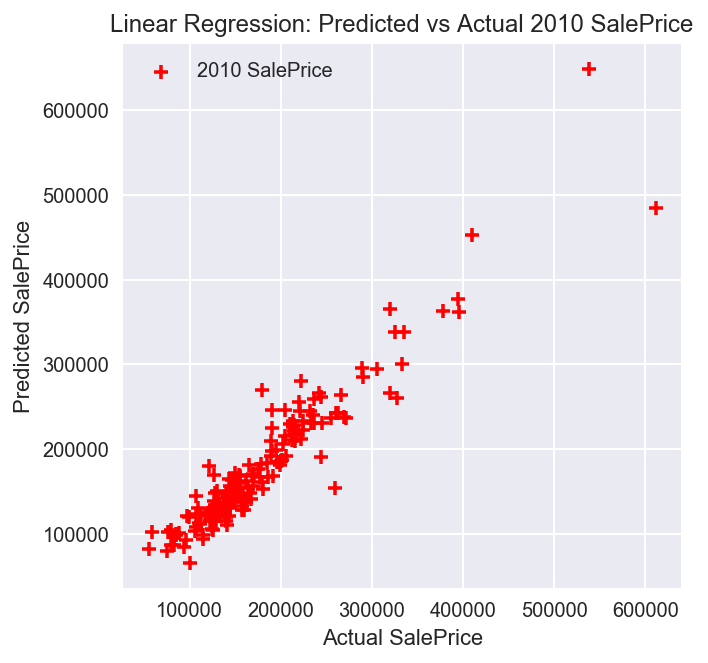

In [72]:
# inverse the log transformation on SalePrice and plot actual vs predicted SalePrice
plt.figure(figsize=(5,5))
plt.scatter(np.exp(y_test), np.exp(y_test_pred), c = "red", marker = '+', label = '2010 SalePrice')
plt.title('Linear Regression: Predicted vs Actual 2010 SalePrice')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.legend(loc = "upper left")
plt.show()

## <font color='blue'><b> Linear Reg Performance: Avg Training R2 = 0.861, Holdout R2 = 0.874

# <font color='blue'><b> MODEL 2: Ridge Regression

In [73]:
# STEP 1a: Initialise StandardScaler as ss
ss = StandardScaler()

# STEP 1b: Fit X_train into ss and perform the transformation concurrently
Xs_train = ss.fit_transform(X_train)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [74]:
# STEP 2a: Specify range to search for optimal alpha
ridge_alphas = np.linspace(0, 1000, 2000)

# STEP 2b: Perform ridge cross validation on Xs_train/y_train across the specified alpha range
optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=5).fit(Xs_train, y_train)

# print optimal alpha
print('Best Alpha:', optimal_ridge.alpha_)

Best Alpha: 144.57228614307155


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [75]:
# STEP 3a: Perform cross validation using optimal alpha
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xs_train, y_train, cv=5)

print('Cross Validation r_squares:', ridge_scores)
print('Mean r_square:', np.mean(ridge_scores))

Cross Validation r_squares: [0.88207415 0.88873986 0.84335917 0.86702857 0.87266034]
Mean r_square: 0.8707724158495814


In [76]:
# STEP 4a: Fit data in ridge
ridge = ridge.fit(Xs_train, y_train)

# STEP 4b: Transform Xs_test USING pre-fitted StandardScaler
Xs_test = ss.transform(X_test)

# STEP 4c: See how well the ridge model scores in the 2010 data
ridge_test_score = ridge.score(Xs_test, y_test)
print('R2 on hold-out:', ridge_test_score)

R2 on hold-out: 0.883489033517361


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """


In [77]:
# predict y on hold-out set
y_test_pred = ridge.predict(Xs_test)

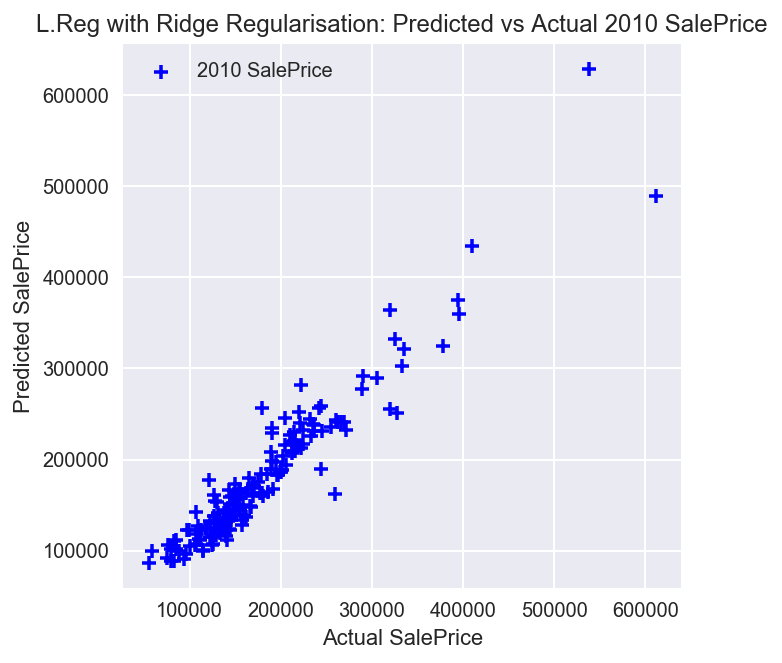

In [78]:
# inverse the log transformation on SalePrice and plot actual vs predicted SalePrice
plt.figure(figsize=(5,5))
plt.scatter(np.exp(y_test), np.exp(y_test_pred), c = "blue", marker = '+', label = '2010 SalePrice')
plt.title('L.Reg with Ridge Regularisation: Predicted vs Actual 2010 SalePrice')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.legend(loc = "upper left")
plt.show()

## <font color='blue'><b> Ridge Performance: Avg Training R2 = 0.87, Holdout R2 = 0.883

# <font color='blue'><b> MODEL 3: Lasso Reg

In [79]:
# STEP 1a: Initialise StandardScaler as ss
ss = StandardScaler()

# STEP 1b: Fit X_train into ss and perform the transformation concurrently
Xs_train = ss.fit_transform(X_train)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [80]:
# STEP 2a: Perform Lasso cross validation on Xs_train/y_train across the specified alpha range
# lassocv automatically selects alphas
optimal_lasso = LassoCV(cv=5).fit(Xs_train, y_train)

print('Best Alpha:', optimal_lasso.alpha_)

Best Alpha: 0.0027760265510893


In [81]:
# STEP 3a: Perform cross validation using optimal alpha
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs_train, y_train, cv=5)

print('Cross Validation r_square:', lasso_scores)
print('Mean r_square:', np.mean(lasso_scores))

Cross Validation r_square: [0.88599658 0.89139282 0.83636409 0.86836217 0.87217068]
Mean r_square: 0.8708572681027318


In [82]:
# STEP 4a: Fit data in lasso
lasso.fit(Xs_train, y_train)

# STEP 4b: Transform Xs_test USING PRE-FITTED StandardScaler
Xs_test = ss.transform(X_test)

# STEP 4c: See how well the lasso model scores in the 2010 data
lasso_test_score = lasso.score(Xs_test, y_test)
print('R2 of hold-out:', lasso_test_score)

R2 of hold-out: 0.893692491895601


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """


In [83]:
# predict y on hold-out set
y_test_pred = lasso.predict(Xs_test)

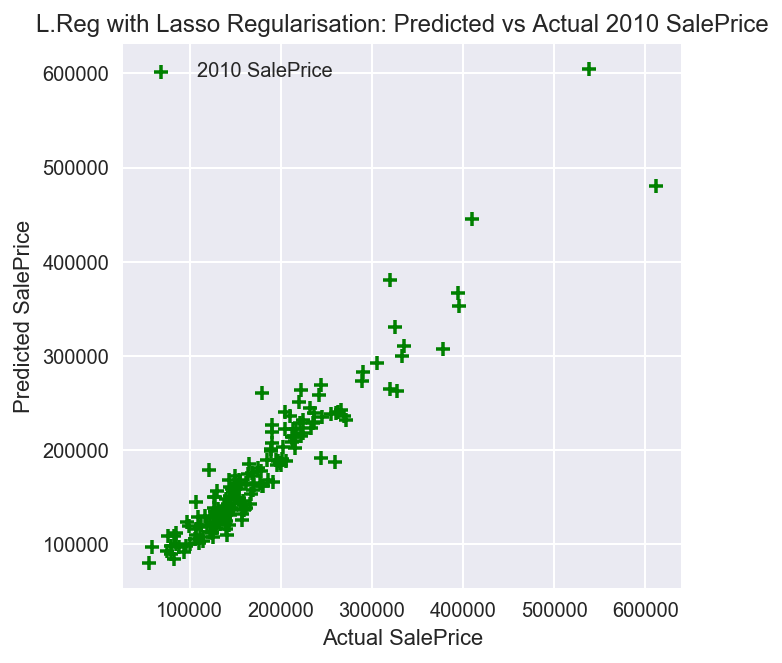

In [84]:
# inverse the log transformation on SalePrice and plot actual vs predicted SalePrice
plt.figure(figsize=(5,5))
plt.scatter(np.exp(y_test), np.exp(y_test_pred), c = "green", marker = '+', label = '2010 SalePrice')
plt.title('L.Reg with Lasso Regularisation: Predicted vs Actual 2010 SalePrice')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.legend(loc = "upper left")
plt.show()

## <font color='blue'><b> Lasso Performance: Avg Training R2 = 0.871, Holdout R2 = 0.894

### <font color='blue'><b> Lasso Regression is my model of choice. Besides slightly outperforming the other two models, Lasso is very suitable in this scenario where multicollinearity between predictors could potentially cause overfitting.

In [85]:
lasso_coefs = pd.DataFrame({'variable':X_train.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

## <font color='blue'><b> Top 20 Predictors of SalePrice:

In [86]:
lasso_coefs[lasso_coefs['abs_coef'] != 0].head(20)

variable      coef  abs_coef
13                TotalSF  0.109309  0.109309
5               GrLivArea  0.068517  0.068517
3            YearRemodAdd  0.057064  0.057064
2               YearBuilt  0.049646  0.049646
46   Neighborhood_NridgHt  0.030177  0.030177
12             Fireplaces  0.028590  0.028590
37   Neighborhood_Crawfor  0.028099  0.028099
10             GarageCars  0.027788  0.027788
11             GarageArea  0.027616  0.027616
6            BsmtFullBath  0.027289  0.027289
67        Condition2_PosN -0.026168  0.026168
52   Neighborhood_StoneBr  0.022961  0.022961
70          BldgType_1Fam  0.021993  0.021993
1                 LotArea  0.020227  0.020227
94    Exterior1st_BrkFace  0.016809  0.016809
30          LandSlope_Sev -0.016147  0.016147
130       BsmtExposure_Gd  0.015550  0.015550
16            MSZoning_RL  0.014699  0.014699
51   Neighborhood_Somerst  0.013570  0.013570
134     GarageType_Attchd  0.012499  0.012499

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [87]:
# approach
# find residuals from model 1.
# freature selection of unfixed features
# use OLS because of interpretability
# find the highest coefficients and those features would be the one that influecnes the variances most
# how to use model 1 and 2? fromi model 1, find those that are undervalued. then run model 2 to find the largest coefficients
y_all = df_fixed['SalePrice'].values
X_all = df_fixed.drop(columns=['SalePrice', 'YrSold'])

In [88]:
# fit_transform full X_all
Xs_full = ss.fit_transform(X_all)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [89]:
# get residuals
y_all_pred = lasso.predict(Xs_full)
residuals = pd.DataFrame(np.exp(y_all_pred) - np.exp(y_all))
residuals.columns = ['ResidualPrice']
residuals.shape

(1448, 1)

In [90]:
# get unfixed features
df_unfixed = df.loc[:, ('OverallQual', 'OverallCond', 'ExterQual', 'ExterCond','BsmtCond','BsmtFinType1',
                        'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2','BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir',
                        'Electrical', 'LowQualFinSF','KitchenQual', 'Functional', 'FireplaceQu',
                        'GarageYrBlt', 'GarageFinish','GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF',
                        'EnclosedPorch', '3SsnPorch','PoolQC', 'Fence')]
df_unfixed = pd.concat([df_unfixed, residuals], axis=1)
df_unfixed = df_unfixed[df_unfixed['ResidualPrice'].notnull()]
df_unfixed.shape

(1448, 29)

# <font color='blue'><b> EDA & Data Cleaning:

### <font color='blue'><b> Map quality ratings to a scale of 1 - 5, 0/1:

In [91]:
# create dict for mapping
rating_convert = {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5, 'N': 0, 'Y': 1, 'Unf': 0, 'LwQ': 1, 'Rec': 2,\
                  'BLQ': 3, 'ALQ':4, 'GLQ': 5}

# map with a for loop iterating through columns
cols = list(df_unfixed.columns)

for each_col in cols:
    df_unfixed[each_col] = df_unfixed[each_col].map(rating_convert).fillna(df_unfixed[each_col])

In [92]:
# check null values
df_unfixed.isnull().sum().sort_values(ascending=False).head(15)

PoolQC           1441
Fence            1170
FireplaceQu       682
GarageFinish       78
GarageCond         78
GarageQual         78
GarageYrBlt        78
BsmtFinType2       38
BsmtFinType1       37
BsmtCond           37
Electrical          1
BsmtFinSF1          0
ResidualPrice       0
BsmtUnfSF           0
ExterCond           0
dtype: int64

### <font color='blue'><b> Electrical:

SBrkr    1323
FuseA      93
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64


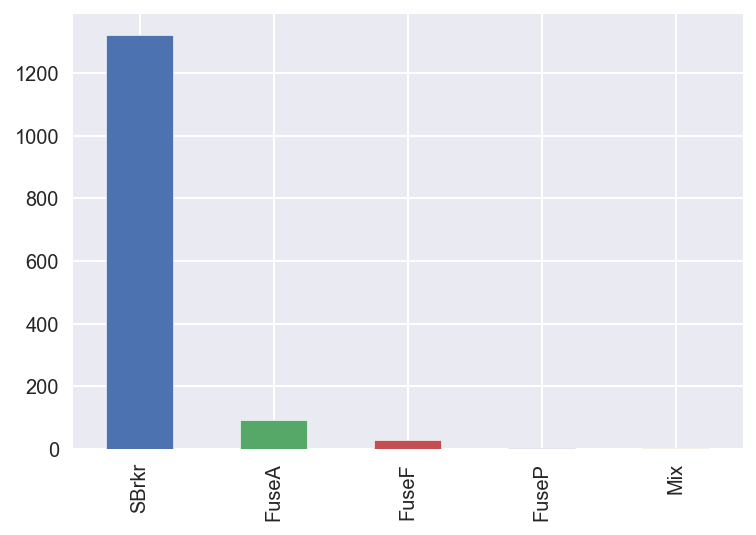

In [93]:
print(df_unfixed['Electrical'].value_counts())
pd.Series(df_unfixed['Electrical']).value_counts().plot('bar')

In [94]:
# replace null value with most common 'SBrkr'
df_unfixed['Electrical'] = df_unfixed['Electrical'].replace(np.nan, 'SBrkr')

### <font color='blue'><b> GarageYrBlt:

In [95]:
# i will drop this column altogether as i doubt the year in which garages were built matters in reality
df_unfixed.drop(columns='GarageYrBlt', inplace=True)

### <font color='blue'><b> Numerical Features:

In [96]:
## seperate categorical features from numerical
df_unfixed.columns.to_series().groupby(df_unfixed.dtypes).groups

{dtype('int64'): Index(['ExterQual', 'ExterCond', 'HeatingQC', 'CentralAir', 'KitchenQual'], dtype='object'),
 dtype('float64'): Index(['OverallQual', 'OverallCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinSF1',
        'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF',
        'FireplaceQu', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF',
        'EnclosedPorch', '3SsnPorch', 'PoolQC', 'ResidualPrice'],
       dtype='object'),
 dtype('O'): Index(['Heating', 'Electrical', 'Functional', 'GarageFinish', 'Fence'], dtype='object')}

In [97]:
df_unfixed.describe()

OverallQual  OverallCond    ExterQual    ExterCond     BsmtCond  \
count  1448.000000  1448.000000  1448.000000  1448.000000  1411.000000   
mean      6.102901     5.572514     3.395718     3.083564     3.010631   
std       1.384500     1.111722     0.573700     0.351607     0.287864   
min       1.000000     1.000000     2.000000     1.000000     1.000000   
25%       5.000000     5.000000     3.000000     3.000000     3.000000   
50%       6.000000     5.000000     3.000000     3.000000     3.000000   
75%       7.000000     6.000000     4.000000     3.000000     3.000000   
max      10.000000     9.000000     5.000000     5.000000     4.000000   

       BsmtFinType1   BsmtFinSF1  BsmtFinType2   BsmtFinSF2    BsmtUnfSF  \
count   1411.000000  1448.000000   1410.000000  1448.000000  1448.000000   
mean       2.637845   444.930939      0.279433    45.911602   566.684392   
std        2.052492   456.879737      0.881118   159.713705   441.491658   
min        0.000000     0.000000      0.000000     0.000000     0.000000   
25%        0.000000     0.000000      0.000000     0.000000   223.750000   
50%        3.000000   384.000000      0.000000     0.000000   474.000000   
75%        5.000000   713.250000      0.000000     0.000000   806.000000   
max        5.000000  5644.000000      5.000000  1474.000000  2336.000000   

           ...        KitchenQual  FireplaceQu   GarageQual   GarageCond  \
count      ...        1448.000000   766.000000  1370.000000  1370.000000   
mean       ...           3.511050     3.460836     2.975912     2.973723   
std        ...           0.662878     0.744764     0.248009     0.240304   
min        ...           2.000000     1.000000     1.000000     1.000000   
25%        ...           3.000000     3.000000     3.000000     3.000000   
50%        ...           3.000000     4.000000     3.000000     3.000000   
75%        ...           4.000000     4.000000     3.000000     3.000000   
max        ...           5.000000     5.000000     5.000000     5.000000   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch    PoolQC  \
count  1448.000000  1448.000000    1448.000000  1448.000000  7.000000   
mean     93.860497    46.722376      22.058702     3.437845  3.714286   
std     124.152424    66.464296      61.296418    29.436993  1.253566   
min       0.000000     0.000000       0.000000     0.000000  2.000000   
25%       0.000000     0.000000       0.000000     0.000000  3.000000   
50%       0.000000    24.000000       0.000000     0.000000  4.000000   
75%     168.000000    68.000000       0.000000     0.000000  4.500000   
max     857.000000   547.000000     552.000000   508.000000  5.000000   

       ResidualPrice  
count    1448.000000  
mean    -1338.172164  
std     23443.336212  
min   -196585.056286  
25%    -11320.908664  
50%      -806.509807  
75%      9362.066843  
max    220699.401006  

[8 rows x 23 columns]

In [98]:
selected_num_feats = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'WoodDeckSF',
                      'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ResidualPrice']
plot_num_feat = df_unfixed.loc[:, selected_num_feats]

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


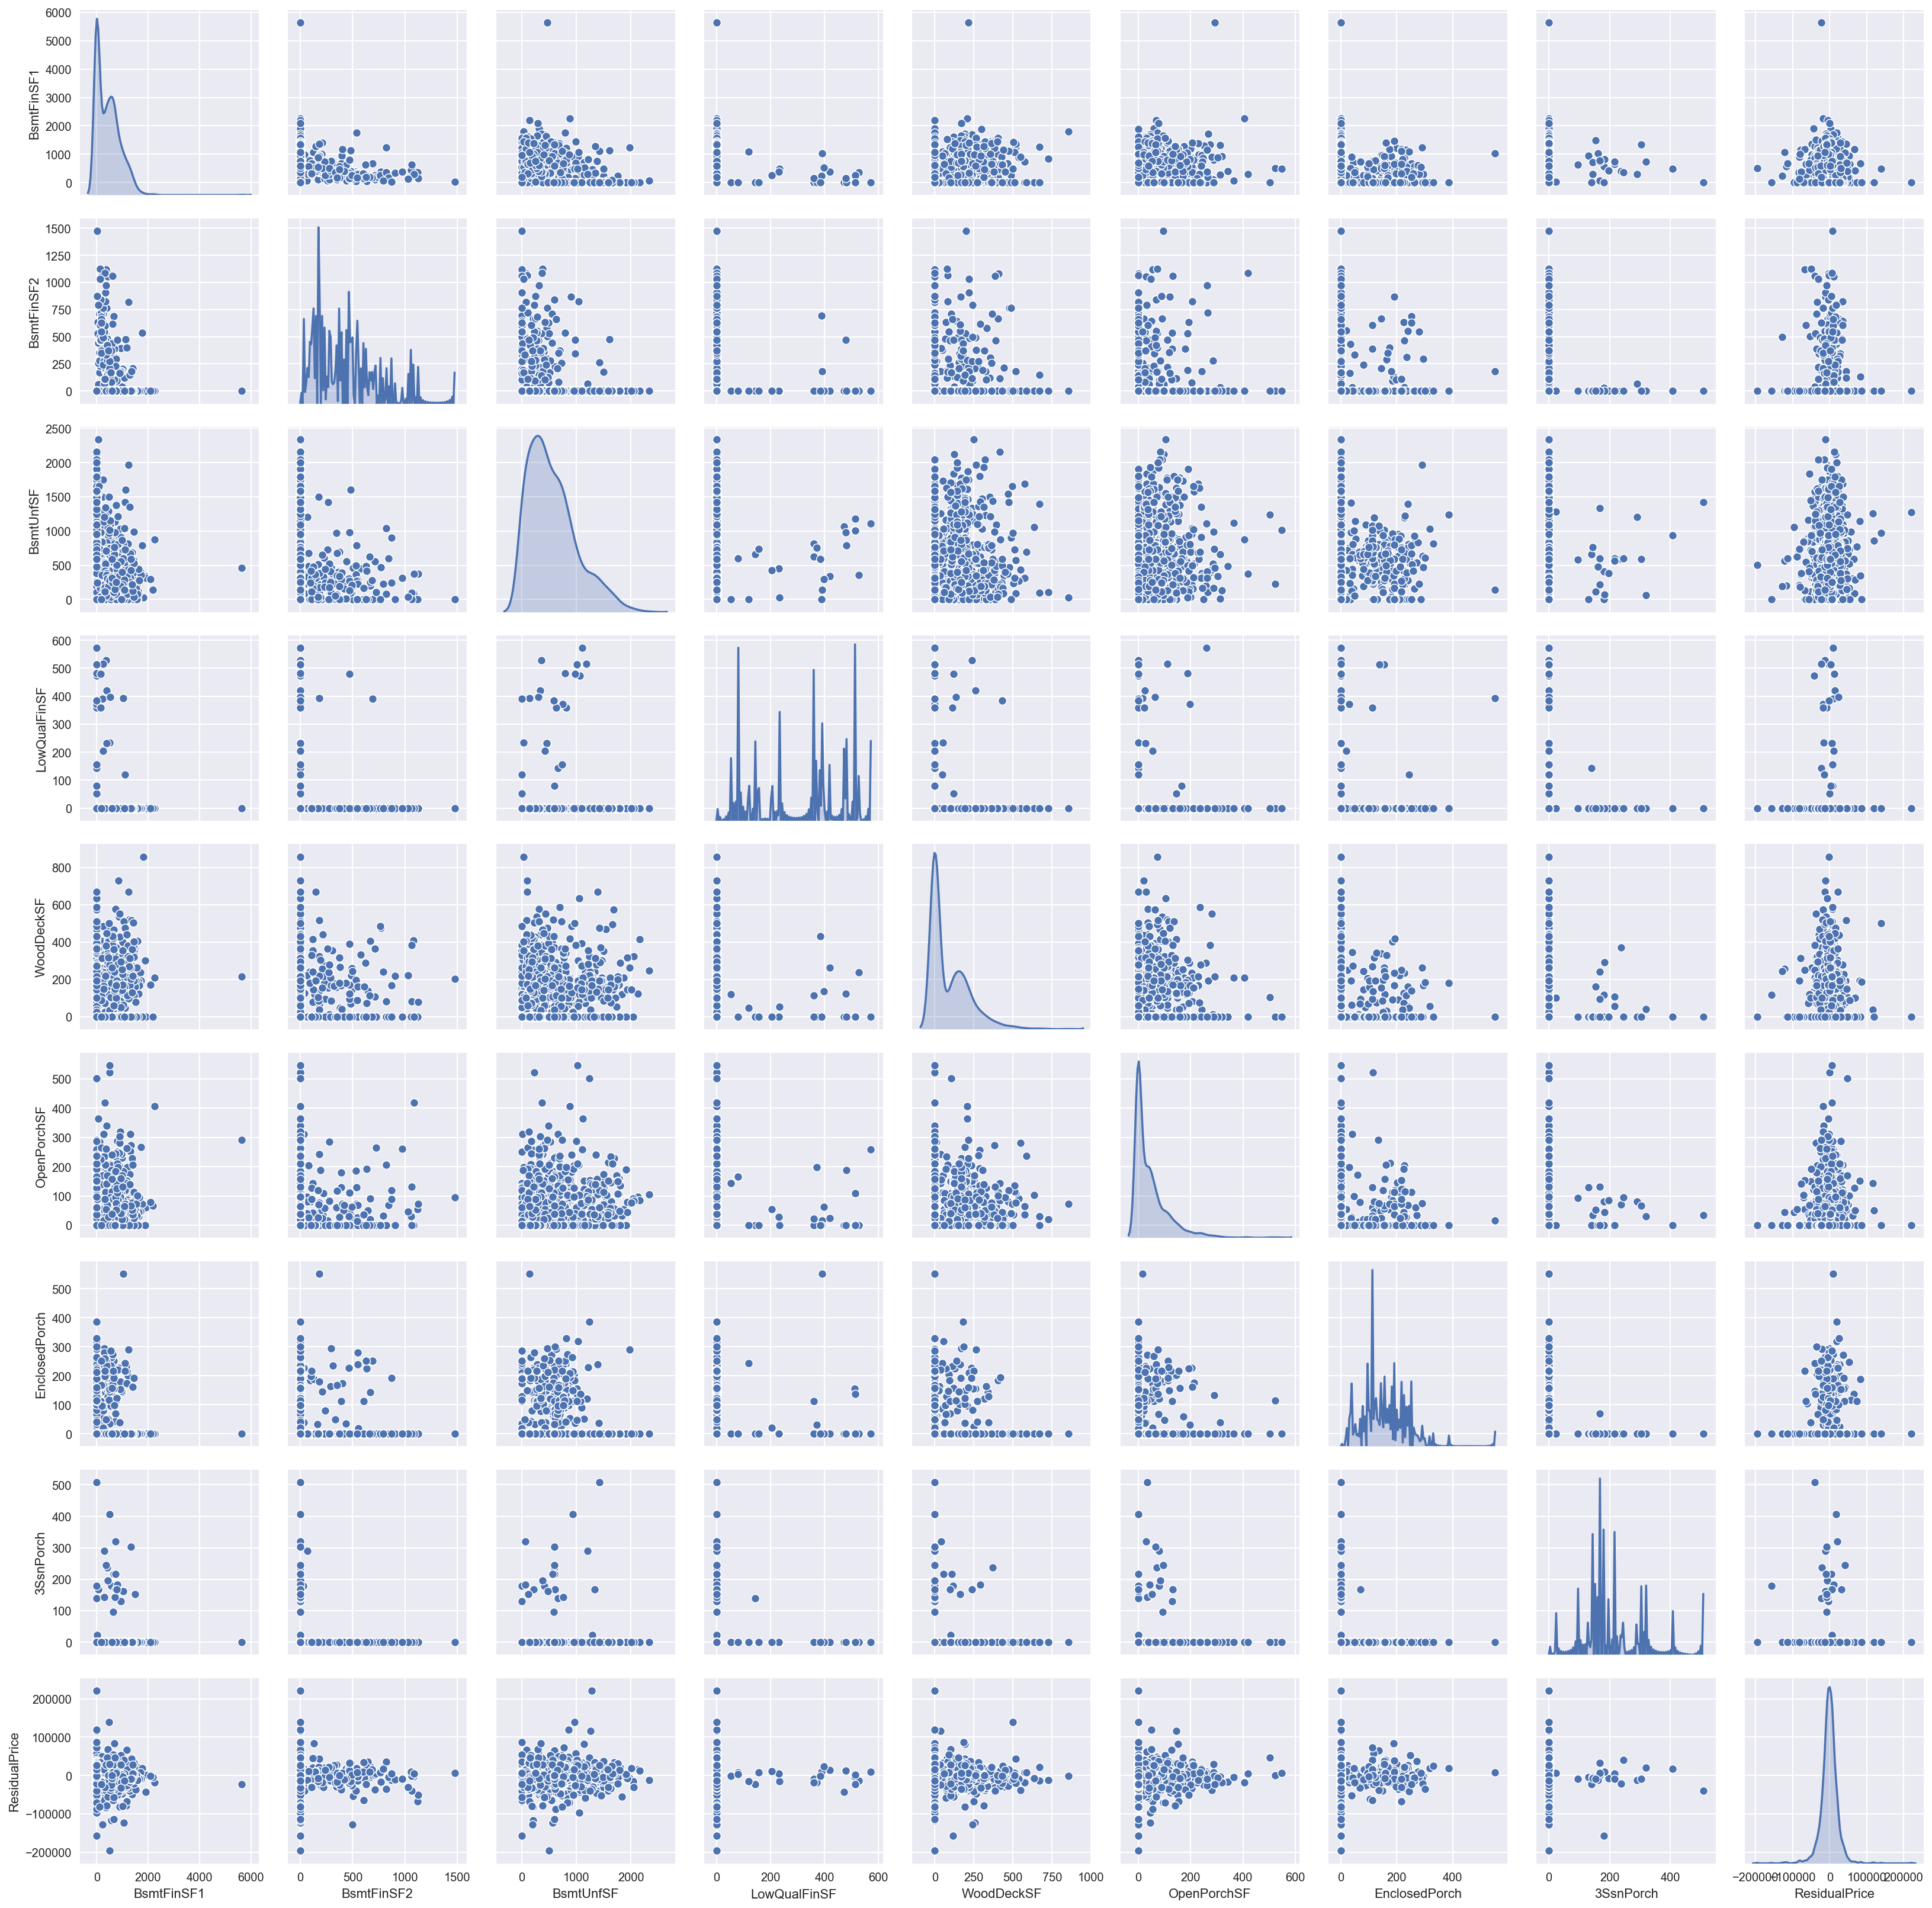

In [99]:
sns.pairplot(plot_num_feat,diag_kind='kde')
plt.show()

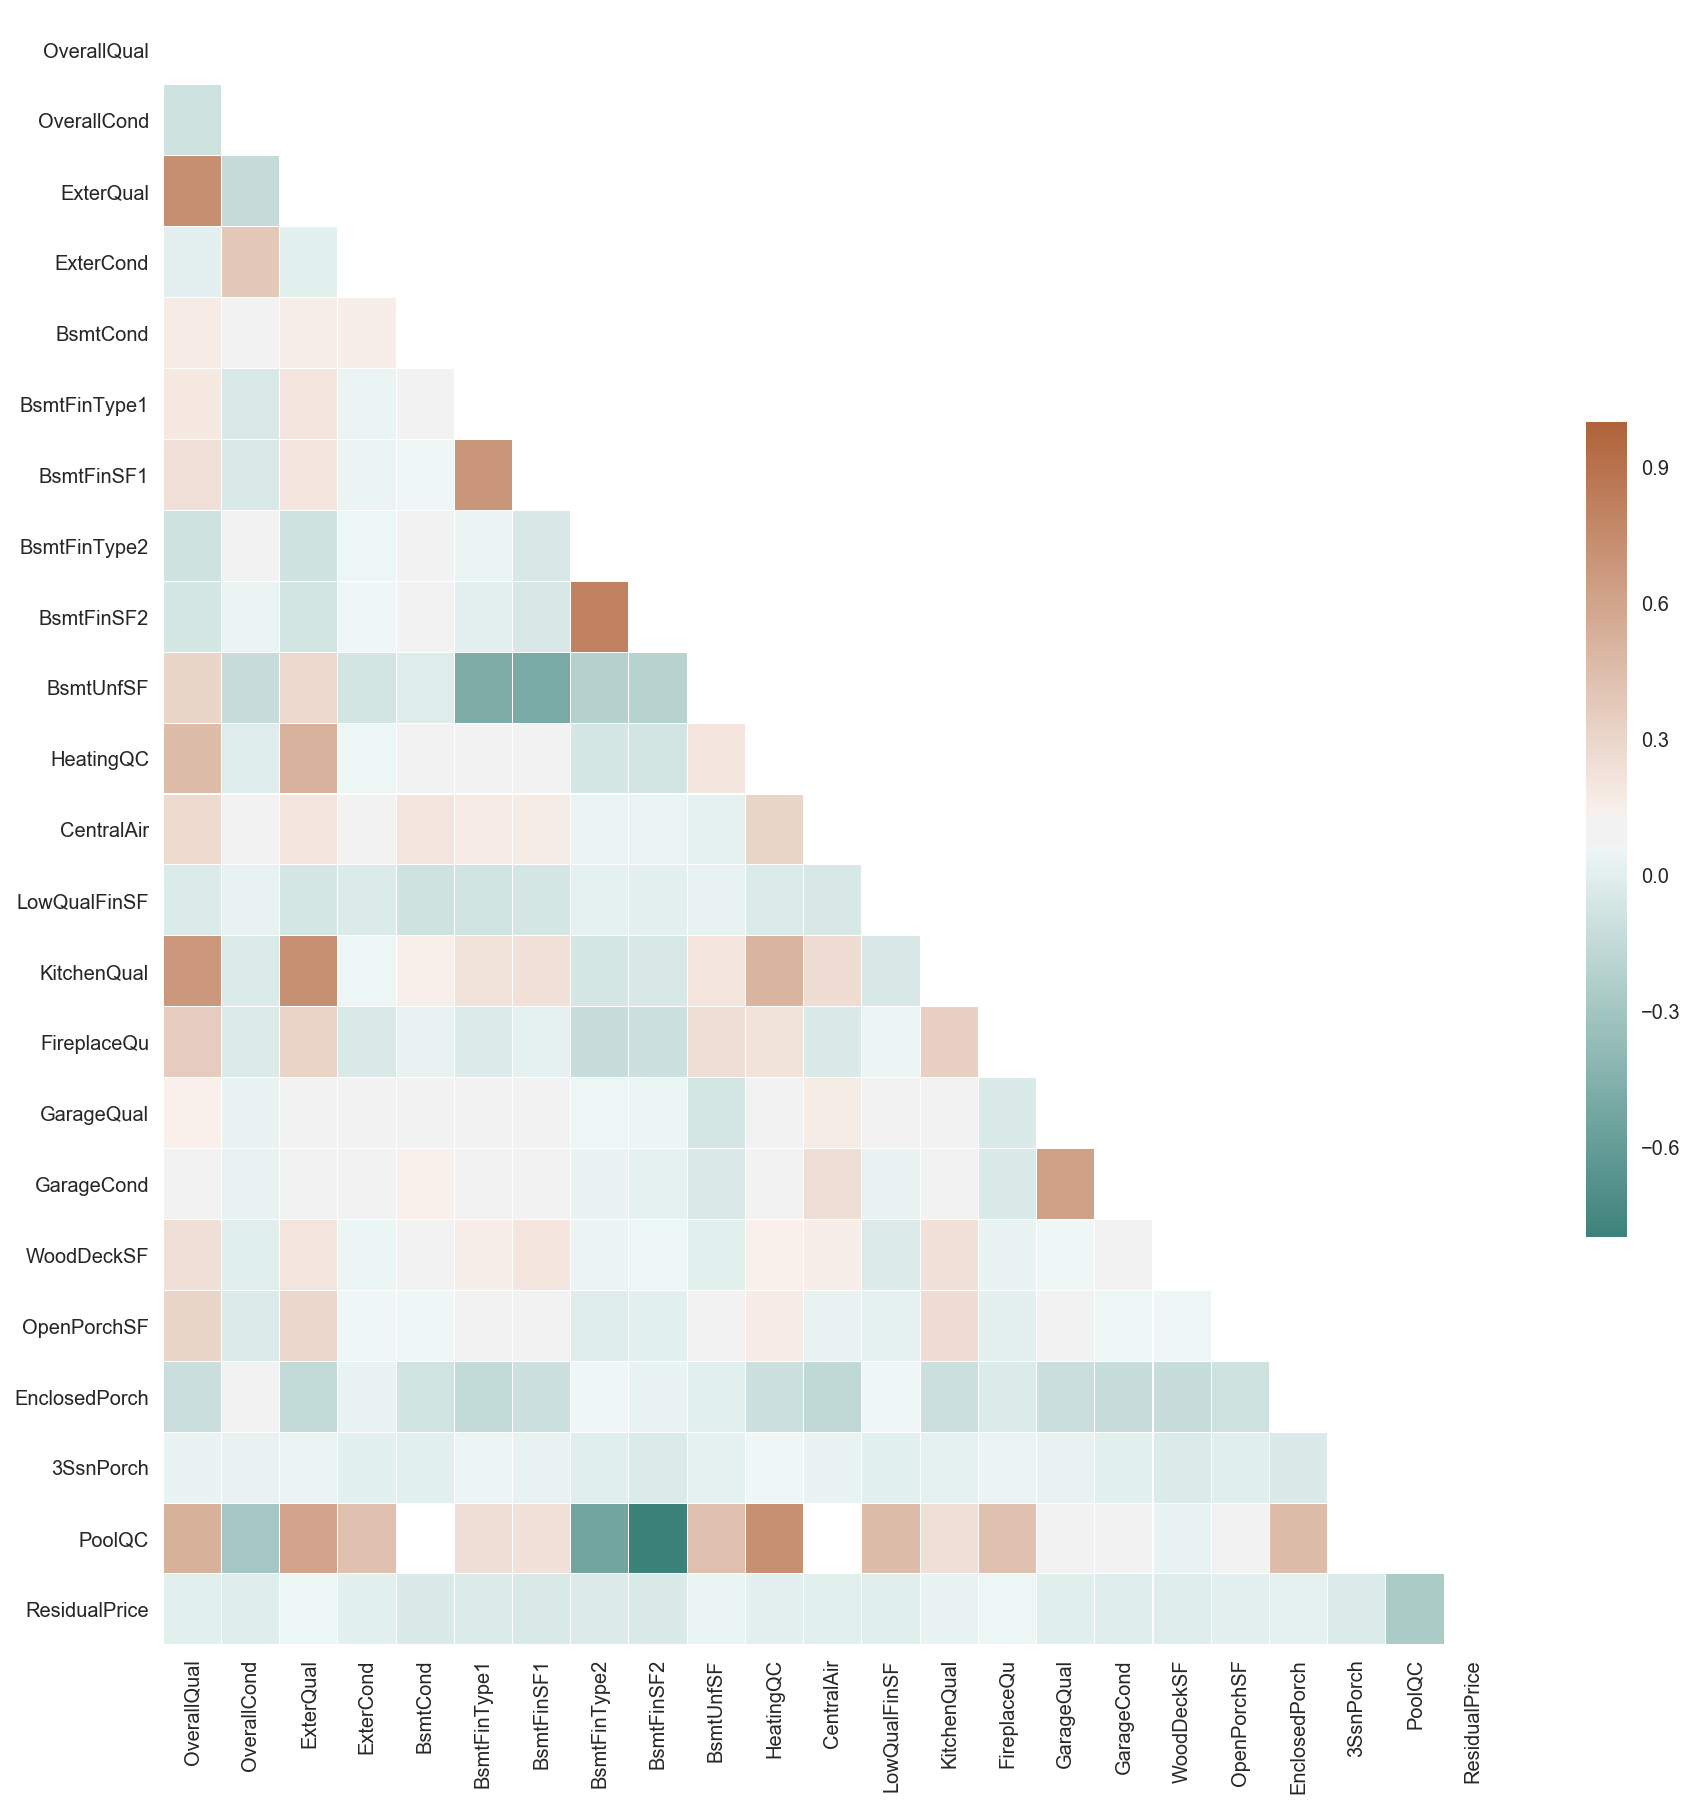

In [100]:
# use heatmap to look at correlation of numerical features against SalePrice
mask = np.zeros_like(df_unfixed.corr())
mask[np.triu_indices_from(mask)]=True
cmap = sns.diverging_palette(180, 30, as_cmap=True)
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(15,15))
    heat=sns.heatmap(df_unfixed.corr(), mask=mask, cmap=cmap, cbar_kws={'shrink':.5}, linewidth=.01);
       
fig=heat.get_figure()

In [101]:
# look at absolute correlation values with respect to SalePrice
corr_list = df_unfixed.corr()
corr_list['ResidualPrice'].abs().sort_values(ascending=False)

ResidualPrice    1.000000
PoolQC           0.258529
FireplaceQu      0.053885
ExterQual        0.053173
BsmtFinSF1       0.044821
BsmtUnfSF        0.040002
BsmtCond         0.039142
BsmtFinSF2       0.038254
KitchenQual      0.033069
3SsnPorch        0.032357
BsmtFinType1     0.027632
BsmtFinType2     0.024871
EnclosedPorch    0.021447
OverallCond      0.017837
GarageCond       0.017747
WoodDeckSF       0.017111
OpenPorchSF      0.012893
GarageQual       0.011892
HeatingQC        0.009105
LowQualFinSF     0.005453
CentralAir       0.003538
ExterCond        0.001840
OverallQual      0.000283
Name: ResidualPrice, dtype: float64

## <font color='blue'><b> Get Dummies for Categorical Features:

In [102]:
X_unfixed.info()

NameError: name 'X_unfixed' is not defined

In [ ]:
# Heating, Electrical, Functional, GarageFinish, Fence

# BsmtFinType1: mean SalePrice for RM is lowest, hence drop it as reference
dummies = pd.get_dummies(df_fixed_cat['MSZoning'], prefix='MSZoning').drop(columns='MSZoning_RM')
dummies.head()

# Alley: null being dropped as reference
temp = pd.get_dummies(df_fixed_cat['Alley'], prefix='Alley')
dummies = pd.concat([dummies, temp], axis=1)

# <font color='blue'><b> Modeling:

In [ ]:
X_unfixed = df_unfixed.drop(columns='ResidualPrice')
X_unfixed = sm.add_constant(X_unfixed)
y_unfixed = df_unfixed['ResidualPrice']

In [ ]:
model = sm.OLS(X_unfixed, y_unfixed).fit()
y_pred = model.predict(X_unfixed)

# # Plot the model
# plt.figure(figsize=(8,6))
# plt.scatter(predictions, y, s=30, marker='+', zorder=10)
# plt.xlabel("Predicted Values - $\hat{y}$")
# plt.ylabel("Actual Values - $y$")
# plt.show()

# print("MSE:", mean_squared_error(y_unfixed, predictions))

In [ ]:
model.summary()

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: